In [1]:
import brainpy.math as bm
import numpy as np
from HDPCCAN_utils import get_tuningMap
from models import HD_cell_L1, PC_cell_L2

#for plotting
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

from scipy.interpolate import interp1d
import pycircstat.descriptive as cd

from scipy.ndimage import gaussian_filter

import sys
sys.path.append('/home/zilong/Desktop/HoneycombSweeps/CircularLinearReg')
from core import cl_corr

%matplotlib inline  
%load_ext autoreload 
%autoreload 2

In [2]:
def simulate_honeycomb_movement(
    total_time=1, 
    dt=0.01, 
    move_prob=0.95, 
    drift_factor=0.0, 
    velocity=0.5, 
    rotation_speed=np.pi / 50,
    stick_length=0.2,
    goal_loc=[0, 0]
):
    
    env_size = 1.0
    time_steps = int(total_time / dt)

    pos_A = np.array([env_size / 2, env_size / 2])
    angle = 0
    pos_B = pos_A + stick_length * np.array([np.cos(angle), np.sin(angle)])
    move_angle = np.random.uniform(-np.pi, np.pi)

    A_trajectory = []   
    B_trajectory = []
    head_directions = []
    rotation_phases = []
    rotation_direction_log = []
    time_list = []
    breakTimepoints = []  # Initialise list


    step_count = 0
    current_time = 0
    just_rotated = False  # New flag to prevent back-to-back rotations

    while step_count < time_steps:
        if (np.random.rand() < move_prob and not just_rotated) or just_rotated:
            
            move_angle = (drift_factor * move_angle) + ((1 - drift_factor) * np.random.uniform(-np.pi, np.pi))
            step_size = velocity * dt
            new_pos_A = pos_A + step_size * np.array([np.cos(move_angle), np.sin(move_angle)])
            new_pos_A = np.clip(new_pos_A, 0, env_size)
            pos_A = new_pos_A
            pos_B = pos_A + stick_length * np.array([np.cos(angle), np.sin(angle)])

            A_trajectory.append(pos_A.copy())
            B_trajectory.append(pos_B.copy())
            head_directions.append(angle)
            rotation_phases.append(False)
            rotation_direction_log.append(0)
            time_list.append(current_time)

            step_count += 1
            current_time += dt
            just_rotated = False  # Reset flag after movement
        else:
            # Randomly choose rotation direction: +1 (CW) or -1 (CCW)
            direction_flag = np.random.choice([1, -1])
            rotation_duration = int(np.random.uniform(0.3, 1.0) / dt)

            for _ in range(min(rotation_duration, time_steps - step_count)):
                angle -= direction_flag * rotation_speed  # CW = -rotation
                angle = (angle + np.pi) % (2 * np.pi) - np.pi
                pos_B = pos_A + stick_length * np.array([np.cos(angle), np.sin(angle)])

                # Check alignment with goal direction
                vec_to_goal = goal_loc - pos_A
                dir_to_goal = np.arctan2(vec_to_goal[1], vec_to_goal[0])
                angle_diff = ((angle - dir_to_goal + np.pi) % (2 * np.pi)) - np.pi  # Wrap to [-π, π]

                # if np.abs(angle_diff) < np.deg2rad(10):  # e.g. 5° threshold
                #     breakTimepoints.append(current_time)  # Record the time when aligned
                #     break  # Stop rotation if aligned

                # if (np.abs(angle_diff) > np.deg2rad(170)):
                #     breakTimepoints.append(current_time)  # Record the time when aligned
                #     break  # Stop rotation if aligned

                A_trajectory.append((pos_A.copy()+pos_B.copy())/2)
                B_trajectory.append(pos_B.copy())
                head_directions.append(angle)
                rotation_phases.append(True)
                rotation_direction_log.append(direction_flag)
                time_list.append(current_time)

                step_count += 1
                current_time += dt
                if step_count >= time_steps:
                    break
                
            just_rotated = True  # Mark that a rotation just occurred

    A_trajectory = np.array(A_trajectory)
    B_trajectory = np.array(B_trajectory)
    head_directions = np.array(head_directions)
    rotation_phases = np.array(rotation_phases)
    rotation_direction_log = np.array(rotation_direction_log)
    time_original = np.array(time_list)

    displacement = np.linalg.norm(np.diff(B_trajectory, axis=0), axis=1)
    speeds = np.concatenate(([0], displacement / dt))

    dt_new = 0.001
    time_upsampled = np.arange(0, time_original[-1] + dt_new, dt_new)

    interp_A_x = interp1d(time_original, A_trajectory[:, 0], kind='linear', fill_value="extrapolate")
    interp_A_y = interp1d(time_original, A_trajectory[:, 1], kind='linear', fill_value="extrapolate")
    interp_B_x = interp1d(time_original, B_trajectory[:, 0], kind='linear', fill_value="extrapolate")
    interp_B_y = interp1d(time_original, B_trajectory[:, 1], kind='linear', fill_value="extrapolate")
    interp_head_dir = interp1d(time_original, head_directions, kind='linear', fill_value="extrapolate")
    interp_speeds = interp1d(time_original, speeds, kind='linear', fill_value="extrapolate")

    # Interpolate all trajectories and parameters
    A_trajectory_upsampled = np.vstack((interp_A_x(time_upsampled), interp_A_y(time_upsampled))).T
    B_trajectory_upsampled = np.vstack((interp_B_x(time_upsampled), interp_B_y(time_upsampled))).T
    head_directions_upsampled = interp_head_dir(time_upsampled)
    speeds_upsampled = interp_speeds(time_upsampled)
    head_directions_upsampled = (head_directions_upsampled + np.pi) % (2 * np.pi) - np.pi

    interp_rotation_phase = interp1d(time_original, rotation_phases, kind='nearest', fill_value="extrapolate")
    rotation_phases_upsampled = interp_rotation_phase(time_upsampled).astype(bool)

    interp_rotation_dir = interp1d(time_original, rotation_direction_log, kind='nearest', fill_value="extrapolate")
    rotation_direction_upsampled = interp_rotation_dir(time_upsampled).astype(int)

    vec_to_goal = goal_loc - B_trajectory_upsampled
    Dir2Goal = np.arctan2(vec_to_goal[:, 1], vec_to_goal[:, 0])

    diff = np.diff(B_trajectory_upsampled, axis=0)
    Velocity = np.zeros_like(B_trajectory_upsampled)
    Velocity[:-1, :] = diff
    MVDirection = (np.arctan2(Velocity[:, 1], Velocity[:, 0]) + np.pi) % (2 * np.pi) - np.pi
    
    break_indices = np.searchsorted(time_upsampled, breakTimepoints)

    return (
        A_trajectory_upsampled,
        B_trajectory_upsampled,
        head_directions_upsampled,
        MVDirection,
        Dir2Goal,
        speeds_upsampled,
        rotation_phases_upsampled,
        time_upsampled,
        Velocity,
        rotation_direction_upsampled,
        break_indices
    )

def discontinuous_plot(ax, x, y, threshold=np.pi, label=None, **kwargs):
    """
    Plot y vs x on ax, breaking the line at discontinuities > threshold.
    Only applies 'label' to the first segment to avoid legend duplication.
    """
    x = np.asarray(x)
    y = np.asarray(y)
    dy = np.abs(np.diff(y))
    breaks = np.where(dy > threshold)[0] + 1
    segments = np.split(np.column_stack([x, y]), breaks)

    for i, seg in enumerate(segments):
        ax.plot(seg[:, 0], seg[:, 1], label=label if i == 0 else None, **kwargs)

## Section 1: Generate simple trajectory to test model parameters

2025-07-13 01:13:19.685751: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Running simulation...
Simulation progress: 0%


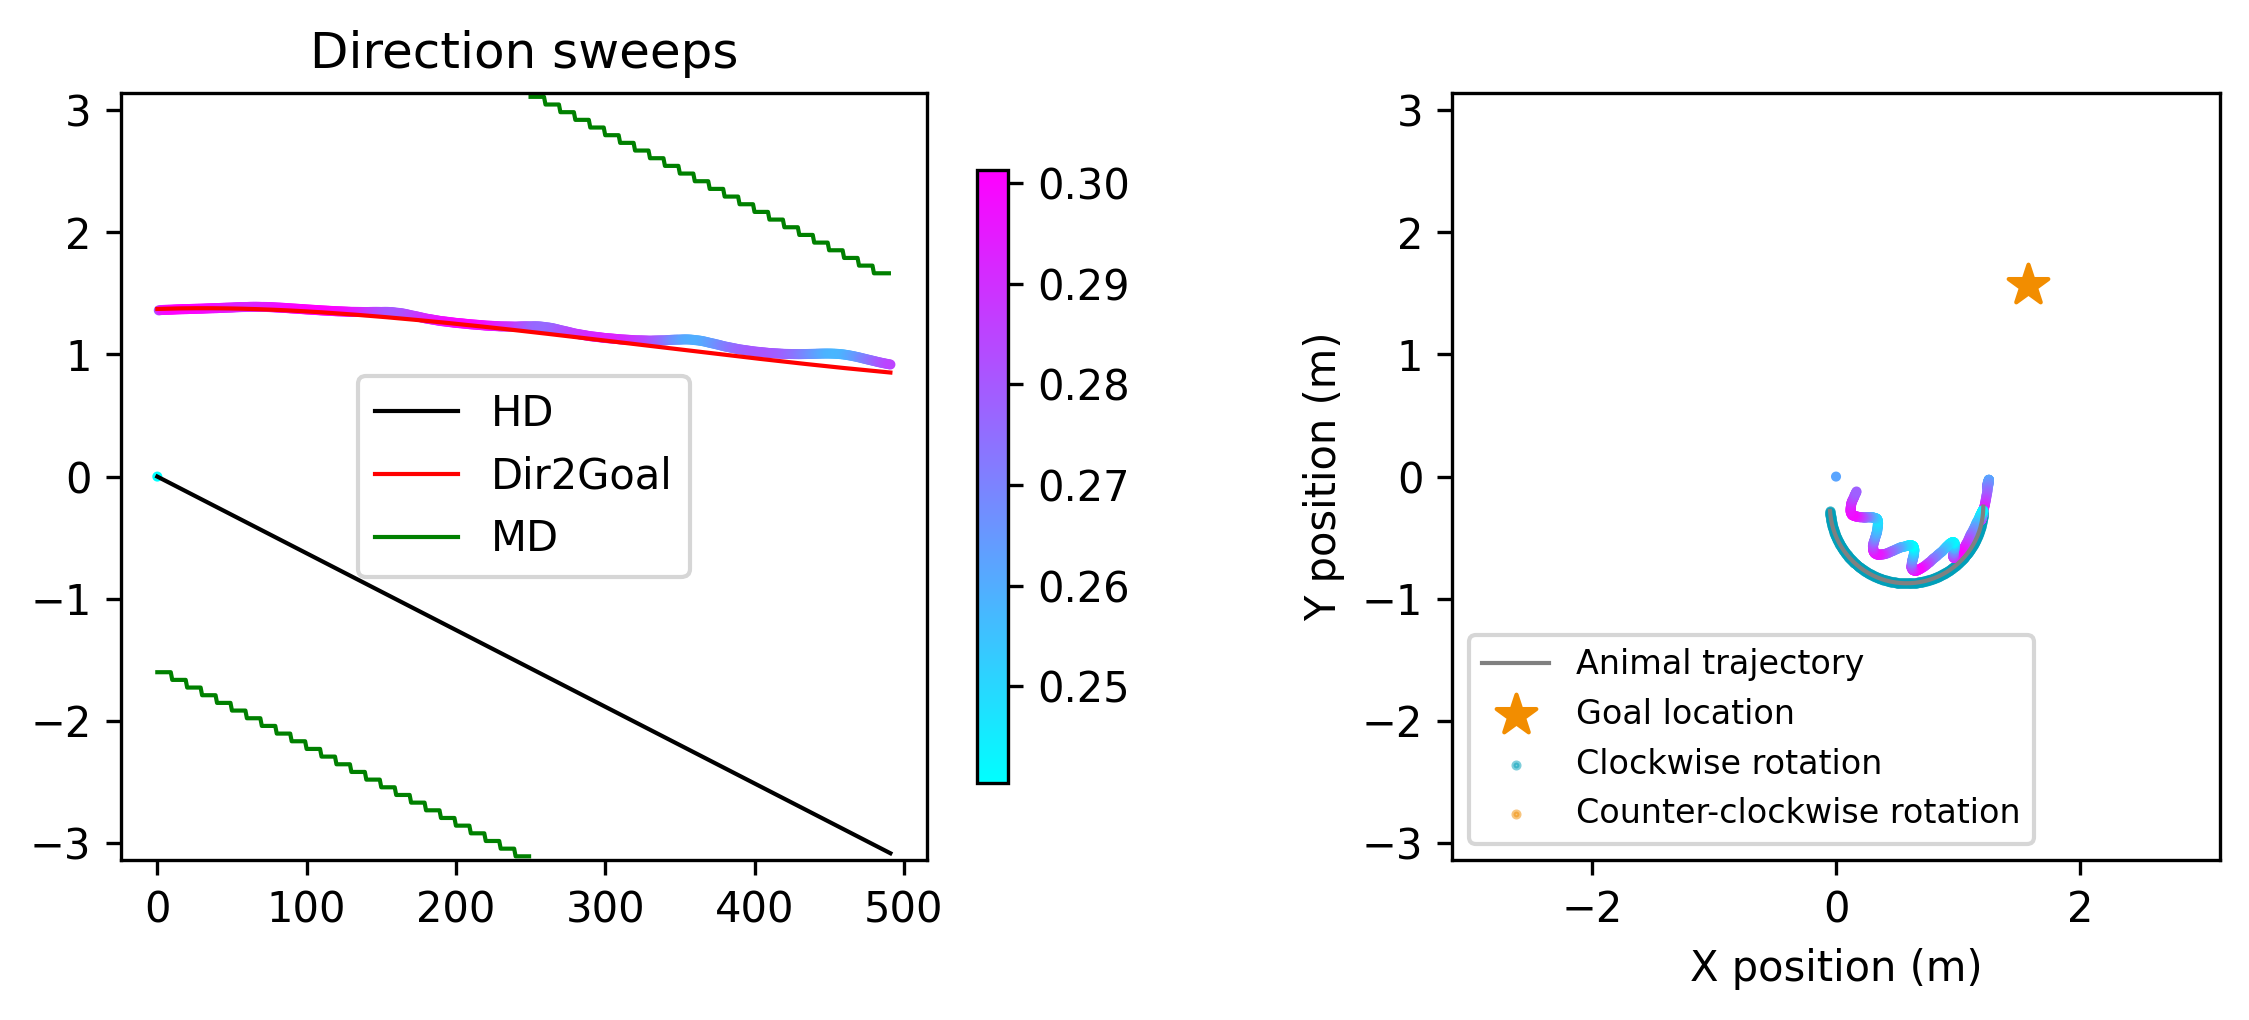

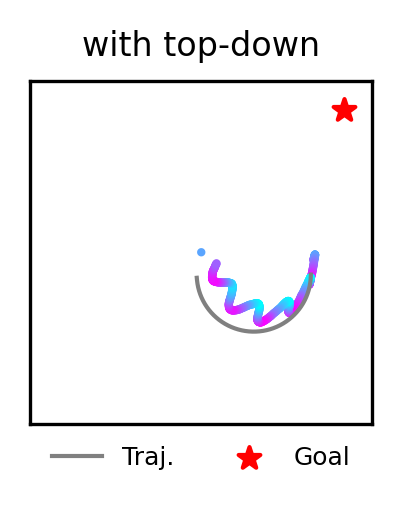

In [3]:
np.random.seed(111)  # For reproducibility

#--------------------------simulate trajectory---------------------------
goal_loc = [0.5*np.pi, 0.5*np.pi]  
goal_loc_in_traj = np.array(goal_loc)/np.pi + 0.5

# Run the function to generate movement data
results = simulate_honeycomb_movement(total_time=0.5, 
                                    dt=0.01, 
                                    move_prob=0.50, 
                                    drift_factor=0.0, 
                                    velocity=20,
                                    rotation_speed=np.pi / 50,
                                    stick_length = 0.2,
                                    goal_loc=goal_loc_in_traj)

Animal_center_all, Animal_location_all, Head_direction_all, MV_direction_all, Dir2Goal_all, Animal_speed_all, rotation_phases, time_upsampled, Animal_Vel_all, Rotation_direction_all, break_indices = results

Animal_location_all = Animal_location_all*np.pi-0.5*np.pi
Animal_speed_all = Animal_speed_all/1000

#--------------------------simulate movement---------------------------

#set simulation parameters
bm.set_platform('gpu')
bm.set_dt(1.0) #ms
bm.clear_buffer_memory(platform='gpu')

v0 = 1.0*bm.pi/1000  #baseline speed
mbar_hd = 10. #HD adaptation strength 
mbar_pc = 1. #GC adaptation strength
noise_stre = 0.
Phase_Offset = 1.5#1.5
theta_hd_modulation = 0.4 # default 0.4; maximal 0.4
theta_gc_modulation = 0.8 # default 0.5; maximal 0.5,
Topdown_mod = 4. # strength of topdown modulation


#construct the model
#layer 1
HD_net = HD_cell_L1(num=100, 
                    noise_stre = noise_stre/6, #gc has muhc more neurons than hd, 10000 vs 100
                    tau=10., 
                    tau_v=100., 
                    k=1., 
                    mbar=mbar_hd, 
                    a=0.4, 
                    A=3., 
                    J0=4., 
                    z_min=-bm.pi, 
                    z_max=bm.pi, 
                    goal_a=0.4, 
                    goal_A=3.0, 
                    topdown=True)

#layer 2
PC_net = PC_cell_L2(noise_stre = noise_stre,
                    num=50,
                    tau = 10.,
                    tau_v = 100.,
                    mbar = mbar_pc,
                    a = 0.5,
                    A = 5, 
                    td_A = 5,
                    J0 = 10.0,
                    k = 1.0,
                    g = 1000,
                    x_min=-bm.pi,
                    x_max=bm.pi,    
                    num_hd = 100,
                    Phase_Offset = Phase_Offset)

# run coupled net
def run_CoupleNet(i, Animal_location, Head_direction, Animal_speed, Dir2Goal): 
    
    A_modulation = (2+Animal_speed/v0)/5
    theta_modulation_stre_hd = theta_hd_modulation * Animal_speed / v0
    theta_modulation_stre_gc = theta_gc_modulation * Animal_speed / v0

    T_theta = 100 #100ms a cycle, i.e., 10 Hz a second
    #calculate TheataModulator at time step i for HD and GC
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta 
    ThetaModulator_HD = 1+theta_modulation_stre_hd*bm.cos(theta_phase*2*bm.pi)
    ThetaModulator_GC = (1+theta_modulation_stre_gc*bm.cos(theta_phase*2*bm.pi)) * A_modulation
    
    #calculate internal head direction
    HD_net.step_run(i, Head_direction, ThetaModulator_HD, Topdown_mod, Dir2Goal)
    HD_bumpcenter = HD_net.center #center of mass of internal direction
    HD_bumpactivity = HD_net.r 
    # print(HD_activity.shape)
        
    #update the grid cell network 
    PC_net.step_run(i, Animal_location, HD_bumpactivity, ThetaModulator_GC, Head_direction)
    
    #get results
    PC_bumpcenter = PC_net.center_bump
    PC_bumpactivity = PC_net.r
    return PC_bumpcenter, HD_bumpcenter, PC_bumpactivity, HD_bumpactivity, theta_phase, ThetaModulator_HD

time_steps = np.arange(len(Animal_location_all))
print('Running simulation...')

@bm.jit
def run(time, pos, hd, speed, d2g):
    return bm.for_loop(run_CoupleNet, (time, pos, hd, speed, d2g))

# pc_activity, pc_bumpcenter, theta_phase, theta_rhythm= bm.for_loop(runNet, (time_steps, Position, Speed))
simulate_time = 50000  #every 50s perform the simulation, otherwise the gpu will run out of memory 

# Pre-allocate arrays
pc_activity = np.empty((len(Animal_location_all), 50, 50))
hd_activity = np.empty((len(Animal_location_all), 100))
pc_bumpcenter = np.empty((len(Animal_location_all), 2))
hd_bumpcenter = np.empty((len(Animal_location_all), 1))
theta_phase = np.empty(len(Animal_location_all))
theta_rhythm = np.empty(len(Animal_location_all))

for i in range(0, len(Animal_location_all), simulate_time):
    print('Simulation progress: %.0f%%' % (i/len(Animal_location_all)*100))
    results = run(time_steps[i:i+simulate_time], 
                    Animal_location_all[i:i+simulate_time], 
                    MV_direction_all[i:i+simulate_time],
                    Animal_speed_all[i:i+simulate_time],
                    Dir2Goal_all[i:i+simulate_time])
    
    pc_bumpcenter_i, hd_bumpcenter_i, pc_activity_i, hd_activity_i, theta_phase_i, theta_rhythm_i = results
    
    #send data to cpu and store them
    pc_activity[i:i+simulate_time,:,:] = np.asarray(pc_activity_i).reshape((-1,50,50))
    hd_activity[i:i+simulate_time,:] = np.asarray(hd_activity_i)
    pc_bumpcenter[i:i+simulate_time,:] = np.asarray(pc_bumpcenter_i)
    hd_bumpcenter[i:i+simulate_time,:] = np.asarray(hd_bumpcenter_i)
    theta_phase[i:i+simulate_time] = np.asarray(theta_phase_i)
    theta_rhythm[i:i+simulate_time] = np.asarray(theta_rhythm_i)
    
#--------------------------plot---------------------------

fig, axs  = plt.subplots(1, 2, figsize=(8,3.5), dpi=300)

ax = axs[0]


start=0
end = len(Animal_location_all)
max_bump_activity = np.max(hd_activity, axis=1)

s_size = 2

ax = axs[0]
discontinuous_plot(ax, time_steps[start:end], Head_direction_all[start:end], threshold=0.5,
                color='black', linewidth=1, label='HD')

discontinuous_plot(ax, time_steps[start:end], Dir2Goal_all[start:end], threshold=0.5,
                color='red', linewidth=1, label='Dir2Goal')

discontinuous_plot(ax, time_steps[start:end], MV_direction_all[start:end], threshold=0.5,
                color='green', linewidth=1, label='MD')

ax.legend()

cb = ax.scatter(time_steps[start:end], 
                hd_bumpcenter[start:end], 
                c=max_bump_activity[start:end], 
                cmap='cool', s=s_size)
ax.set_ylim(-bm.pi, bm.pi)
#colorbar
cbar = plt.colorbar(cb, ax=ax, shrink=0.8)
ax.set_title('Direction sweeps')

ax = axs[1]
num = 50
z_max = np.pi
time_steps = np.arange(len(Animal_location_all))
max_r_grid = np.max(pc_activity, axis=(1,2)) 

# Static plot for position and bump center in the second subplot (axs[1])
ax.plot(Animal_location_all[:, 0], Animal_location_all[:, 1], color='grey', linewidth=1, label='Animal trajectory')
ax.scatter(goal_loc[0], goal_loc[1], color='#F28D00', marker='*', s=100, label='Goal location')

#color animal trajectory during rotation 
mask = Rotation_direction_all == 1
ax.scatter(Animal_location_all[mask, 0], Animal_location_all[mask, 1], 
           color='#009FB9', s=2, label='Clockwise rotation', alpha=0.5)

mask = Rotation_direction_all == -1
ax.scatter(Animal_location_all[mask, 0], Animal_location_all[mask, 1], 
           color='#F18D00', s=2, label='Counter-clockwise rotation', alpha=0.5)

sc = ax.scatter(
                pc_bumpcenter[:, 0],
                pc_bumpcenter[:, 1],
                c=max_r_grid,
                cmap="cool",
                s=2,
        )

ax.set_aspect('equal')
ax.set_xlim(-np.pi,np.pi)

ax.set_ylim(-np.pi,np.pi)
ax.legend(fontsize=8)
ax.set_xlabel('X position (m)', fontsize=10)
ax.set_ylabel('Y position (m)', fontsize=10)

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HoneycombSweeps/figures/PaperFig/Example_Sweeps.pdf', dpi=300)


#---------------------------Generate paper figure--------------------------------

fig, ax  = plt.subplots(1, 1, figsize=(1.8,1.8), dpi=300)

num = 50
z_max = np.pi
time_steps = np.arange(len(Animal_location_all))
max_r_grid = np.max(pc_activity, axis=(1,2)) 

# Static plot for position and bump center in the second subplot (axs[1])
ax.plot(Animal_location_all[:, 0], Animal_location_all[:, 1], color='grey', linewidth=1.0, label='Traj.')
ax.scatter(goal_loc[0], goal_loc[1], color='red', marker='*', s=30, label='Goal')

sc = ax.scatter(
                pc_bumpcenter[:, 0],
                pc_bumpcenter[:, 1],
                c=max_r_grid,
                cmap="cool",
                s=1,
        )


#remove the ticks
ax.tick_params(axis='both', which='both', length=0)
#remove tick labels
ax.set_xticks([])
ax.set_yticks([])

ax.set_aspect('equal')
ax.set_xlim(-0.6*np.pi,0.6*np.pi)
ax.set_ylim(-0.6*np.pi,0.6*np.pi)
# ax.set_title('w/o top-down', fontsize=8)
ax.set_title('with top-down', fontsize=8)

ax.legend(fontsize=6, frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.), ncol=2)

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HoneycombSweeps/figures/PaperFig/Example_Sweeps_goal_td.pdf', dpi=300)

## Section 2: simulate a long spinning trajectory and run the network

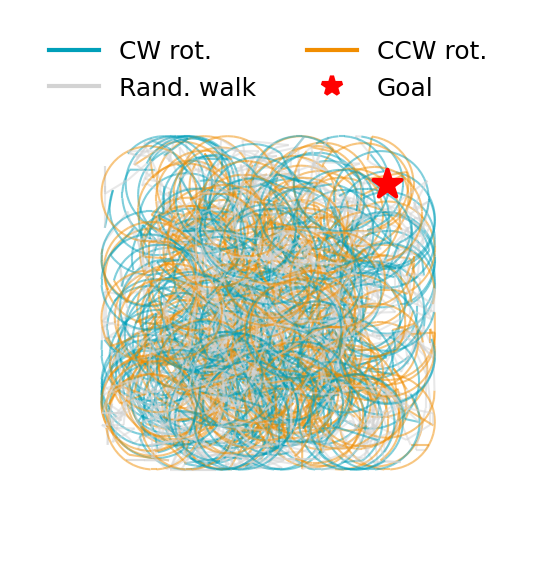

In [4]:
# Seed for reproducibility
# np.random.seed(111)
goal_loc = [0.5*np.pi, 0.5*np.pi]

goal_loc_in_traj = np.array(goal_loc)/np.pi + 0.5

results = simulate_honeycomb_movement(total_time=300, 
                                    dt=0.01, 
                                    move_prob=0.90, 
                                    drift_factor=0.0, 
                                    velocity=10,
                                    rotation_speed=np.pi / 50,
                                    stick_length = 0.2,
                                    goal_loc=goal_loc_in_traj)

Animal_center_all, Animal_location_all, Head_direction_all, MV_direction_all, Dir2Goal_all, Animal_speed_all, rotation_phases, time_upsampled, Animal_Vel_all, Rotation_direction_all, break_indices = results


Animal_center_all = Animal_center_all*np.pi-0.5*np.pi
Animal_location_all = Animal_location_all*np.pi-0.5*np.pi
Animal_speed_all /= 1000

fig, ax = plt.subplots(1, 1, figsize=(4, 2), dpi=300)

# # Create line segments and assign colours
# segments = np.array([
#     [Animal_location_all[i], Animal_location_all[i + 1]] 
#     for i in range(len(Animal_location_all) - 1)
# ])

# colors = []
# for i in range(len(Animal_location_all) - 1):
#     if rotation_phases[i]:
#         if Rotation_direction_all[i] == 1:
#             colors.append('#009FB9')  # Clockwise: purple
#         elif Rotation_direction_all[i] == -1:
#             colors.append('#F18D00')   # Counterclockwise: orange
#         else:
#             colors.append('lightgrey')  # Should not occur
#     else:
#         colors.append('lightgrey')      # Movement phase

# ====== Downsample the trajectory for plotting ======
stride = 20  # Adjust this to balance quality vs. file size
downsampled_locs = Animal_location_all[::stride]
downsampled_phases = rotation_phases[::stride]
downsampled_dirs = Rotation_direction_all[::stride]

# Ensure equal length by clipping to minimum
min_len = min(len(downsampled_locs), len(downsampled_phases), len(downsampled_dirs))
downsampled_locs = downsampled_locs[:min_len]
downsampled_phases = downsampled_phases[:min_len]
downsampled_dirs = downsampled_dirs[:min_len]

# Create line segments
segments = np.array([
    [downsampled_locs[i], downsampled_locs[i + 1]]
    for i in range(min_len - 1)
])

# Assign colour to each segment
colors = []
for i in range(min_len - 1):
    if downsampled_phases[i]:
        if downsampled_dirs[i] == 1:
            colors.append('#009FB9')  # CW
        elif downsampled_dirs[i] == -1:
            colors.append('#F18D00')  # CCW
        else:
            colors.append('lightgrey')  # Unexpected
    else:
        colors.append('lightgrey')  # Movement

# Add to plot
lc = LineCollection(segments, colors=colors, linewidths=0.5, alpha=0.5)
ax.add_collection(lc)
ax.set_aspect('equal')
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)

# Plot goal location
ax.scatter(goal_loc[0], goal_loc[1], color='red', marker='*', s=50, zorder=10)

# Define custom legend handles
legend_elements = [
    Line2D([0], [0], color='#009FB9', lw=1.0, label='CW rot.'),
    Line2D([0], [0], color='lightgrey', lw=1.0, label='Rand. walk'),
    Line2D([0], [0], color='#F18D00', lw=1.0, label='CCW rot.'),
    Line2D([0], [0], color='red', marker='*', lw=0, markersize=5, label='Goal')
]

# Add legend outside the plot box (right side)
ax.legend(handles=legend_elements, 
          loc='upper center', 
          bbox_to_anchor=(0.5, 1.1), 
          frameon=False, 
          fontsize=6, ncol=2)

#axis off
ax.axis('off')

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HoneycombSweeps/figures/PaperFig/Long_spinning_traj.pdf', dpi=300)

In [5]:
def get_relativeDir2Goal(Animal_location, Head_direction, goal_loc):
    """
    Compute the relative direction to the goal for each position and head direction.
    
    Parameters:
    - Animal_location_all: Array of animal positions (Nx2).
    - Head_direction_all: Array of head directions (N,).
    - goal_loc: Goal location as a 2D array [x, y].
    
    Returns:
    - relative_angle2goal: Array of relative angles to the goal (N,).
    """

    # Ensure goal_loc is a numpy array
    goal_loc = np.array(goal_loc)

    # Vector from current position to consink
    vec = goal_loc - Animal_location  # shape (N, 2)
    vec_angle = np.arctan2(vec[:, 1], vec[:, 0])  # angle to consink

    # Compute head-relative angle, wrap to [-π, π]
    relative_angle2goal = (vec_angle - Head_direction + np.pi) % (2 * np.pi) - np.pi
        
    return relative_angle2goal

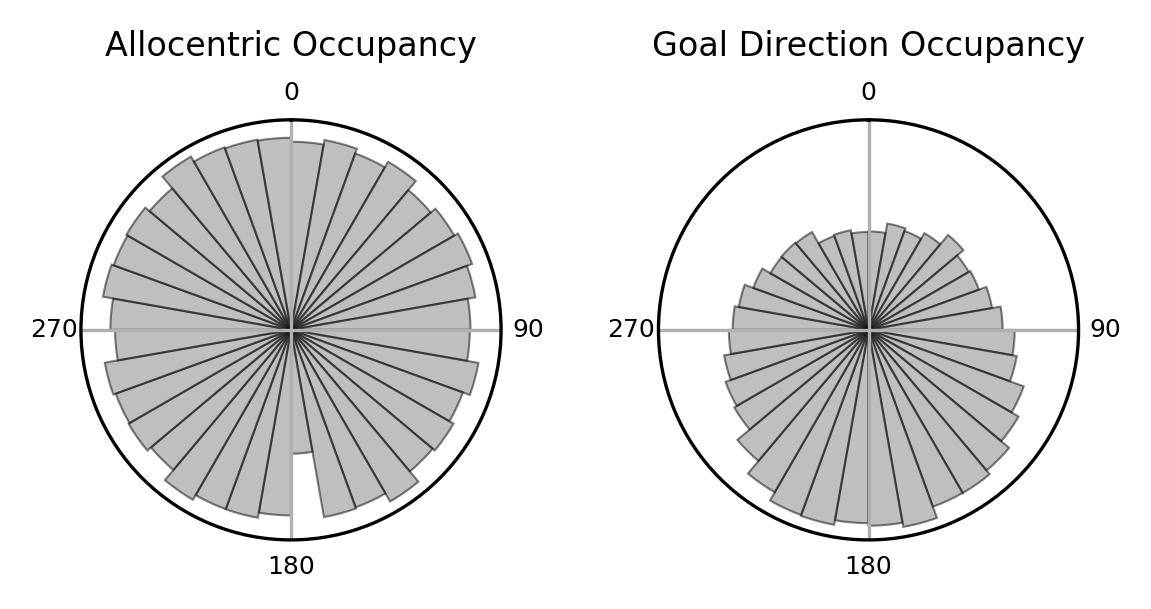

In [6]:
#polor plot of all head direction
fig = plt.figure(figsize=(4, 2), dpi=300)

gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0], projection='polar')

ax1.hist(Head_direction_all[Rotation_direction_all!=0], bins=36, color='grey', edgecolor='black', linewidth=0.5, alpha=0.5)
ax1.set_title('Allocentric Occupancy', fontsize=8)


ax2 = fig.add_subplot(gs[1], projection='polar')

#get relative angles to the goal
relative_angle = get_relativeDir2Goal(Animal_location_all, Head_direction_all, goal_loc)
# relative_angle = get_relativeDir2Goal(Animal_center_all, Head_direction_all, goal_loc)

ax2.hist(relative_angle, bins=36, color='grey', edgecolor='black', linewidth=0.5, alpha=0.5)
ax2.set_title('Goal Direction Occupancy', fontsize=8)

for ax in [ax1, ax2]:
    # Polar aesthetics
    ax.set_theta_zero_location('N')  # 0 at top
    ax.set_theta_direction(-1)       # clockwise
    #only show 0, 90, 180, 270
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
    ax.set_xticklabels(['0', '90', '180', '270'])
    #remove y ticks
    ax.set_yticks([])
    #xtick fontsize as 6
    ax.tick_params(labelsize=6)
    ax.xaxis.set_tick_params(pad=-4)
    
plt.tight_layout()



In [7]:
#set simulation parameters
bm.set_platform('gpu')
bm.set_dt(1.0) #ms
bm.clear_buffer_memory(platform='gpu')

v0 = 1.0*bm.pi/1000  #baseline speed
mbar_hd = 10#5 #5. #HD adaptation strength 
mbar_pc = 8#5 #5. #GC adaptation strength
noise_stre = 0.
Phase_Offset = 1.5#1.5 #1.5
theta_hd_modulation = 0.4 # default 0.4; maximal 0.4
theta_gc_modulation = 0.5 #0.8 # default 0.5; maximal 0.5,
Topdown_mod = 4.0 # strength of topdown modulation


#construct the model
#layer 1
HD_net = HD_cell_L1(num=100, 
                    noise_stre = noise_stre/6, #gc has muhc more neurons than hd, 10000 vs 100
                    tau=10., 
                    tau_v=100., 
                    k=1., 
                    mbar=mbar_hd, 
                    a=0.4, 
                    A=3., 
                    J0=4., 
                    z_min=-bm.pi, 
                    z_max=bm.pi, 
                    goal_a=0.4, 
                    goal_A=3.0, 
                    topdown=True)

#layer 2
PC_net = PC_cell_L2(noise_stre = noise_stre,
                    num=50,
                    tau = 10.,
                    tau_v = 100.,
                    mbar = mbar_pc,
                    a = 0.7,
                    A = 5, 
                    td_A = 5,
                    J0 = 10.0,
                    k = 1.0,
                    g = 1000,
                    x_min=-bm.pi,
                    x_max=bm.pi,    
                    num_hd = 100,
                    Phase_Offset = Phase_Offset)

# run coupled net
def run_CoupleNet(i, Animal_location, Head_direction, Animal_speed, Dir2Goal): 
    
    A_modulation = (2+Animal_speed/v0)/5
    theta_modulation_stre_hd = theta_hd_modulation * Animal_speed / v0
    theta_modulation_stre_gc = theta_gc_modulation * Animal_speed / v0

    T_theta = 100 #100ms a cycle, i.e., 10 Hz a second
    #calculate TheataModulator at time step i for HD and GC
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta 
    ThetaModulator_HD = 1+theta_modulation_stre_hd*bm.cos(theta_phase*2*bm.pi)
    ThetaModulator_GC = (1+theta_modulation_stre_gc*bm.cos(theta_phase*2*bm.pi)) * A_modulation
    
    #calculate internal head direction
    HD_net.step_run(i, Head_direction, ThetaModulator_HD, Topdown_mod, Dir2Goal)
    HD_bumpcenter = HD_net.center #center of mass of internal direction
    HD_bumpactivity = HD_net.r 
    # print(HD_activity.shape)
        
    #update the grid cell network 
    PC_net.step_run(i, Animal_location, HD_bumpactivity, ThetaModulator_GC, Head_direction)
    
    #get results
    PC_bumpcenter = PC_net.center_bump
    PC_bumpactivity = PC_net.r
    return PC_bumpcenter, HD_bumpcenter, PC_bumpactivity, HD_bumpactivity, theta_phase, ThetaModulator_HD

time_steps = np.arange(len(Animal_location_all))
print('Running simulation...')

@bm.jit
def run(time, pos, hd, speed, d2g):
    return bm.for_loop(run_CoupleNet, (time, pos, hd, speed, d2g))

# pc_activity, pc_bumpcenter, theta_phase, theta_rhythm= bm.for_loop(runNet, (time_steps, Position, Speed))
simulate_time = 50000  #every 50s perform the simulation, otherwise the gpu will run out of memory 

# Pre-allocate arrays
pc_activity = np.empty((len(Animal_location_all), 50, 50))
hd_activity = np.empty((len(Animal_location_all), 100))
pc_bumpcenter = np.empty((len(Animal_location_all), 2))
hd_bumpcenter = np.empty((len(Animal_location_all), 1))
theta_phase = np.empty(len(Animal_location_all))
theta_rhythm = np.empty(len(Animal_location_all))

for i in range(0, len(Animal_location_all), simulate_time):
    print('Simulation progress: %.0f%%' % (i/len(Animal_location_all)*100))
    pc_bumpcenter_i, hd_bumpcenter_i, pc_activity_i, hd_activity_i, theta_phase_i, theta_rhythm_i = run(time_steps[i:i+simulate_time], 
                                                                                                        Animal_location_all[i:i+simulate_time], 
                                                                                                        MV_direction_all[i:i+simulate_time],
                                                                                                        Animal_speed_all[i:i+simulate_time],
                                                                                                        Dir2Goal_all[i:i+simulate_time])
    #send data to cpu and store them
    pc_activity[i:i+simulate_time,:,:] = np.asarray(pc_activity_i).reshape((-1,50,50))
    hd_activity[i:i+simulate_time,:] = np.asarray(hd_activity_i)
    pc_bumpcenter[i:i+simulate_time,:] = np.asarray(pc_bumpcenter_i)
    hd_bumpcenter[i:i+simulate_time,:] = np.asarray(hd_bumpcenter_i)
    theta_phase[i:i+simulate_time] = np.asarray(theta_phase_i)
    theta_rhythm[i:i+simulate_time] = np.asarray(theta_rhythm_i)

Running simulation...
Simulation progress: 0%
Simulation progress: 17%
Simulation progress: 33%
Simulation progress: 50%
Simulation progress: 67%
Simulation progress: 83%


## Section 3: plot exmaple place fields

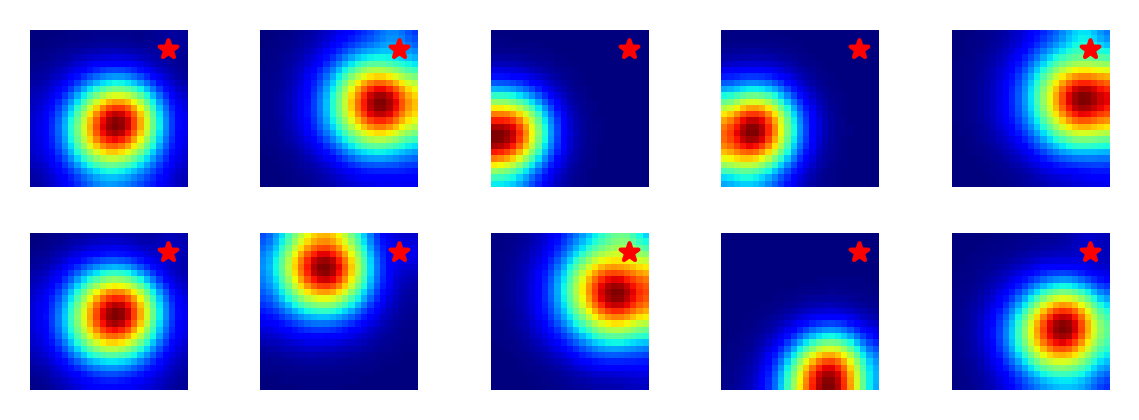

In [8]:

#plot all the firing rates in a single merged image
fig, axs = plt.subplots(2, 5, figsize=(4,1.5), dpi=300)

dim = num//2
Position_norm = (Animal_location_all - Animal_location_all.min() - 1e-5)/(Animal_location_all.max() - Animal_location_all.min())
#mark the goal location
goal_x = (goal_loc[0]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*dim
goal_y = (goal_loc[1]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*dim

for i in range(10):
    cellindex_x = np.random.randint(12, 38)
    cellindex_y = np.random.randint(12, 38)
    map = get_tuningMap(pc_activity, 
                        Position_norm, 
                        cellindex_x=cellindex_x,
                        cellindex_y=cellindex_y,
                        filter= True,
                        samples_per_sec=1000,
                        dim=dim)
    
    #5 row and 2 cols
    ax = axs[i // 5, i % 5]

    ax.scatter(goal_x, goal_y, color='red', marker='*', s=20)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')  
    ax.imshow(map, cmap='jet', origin='lower')

plt.tight_layout()
plt.savefig('/home/zilong/Desktop/HoneycombSweeps/figures/PaperFig/Example_place_maps.pdf', dpi=300)


## Section 4: plot goal-directed sweeps

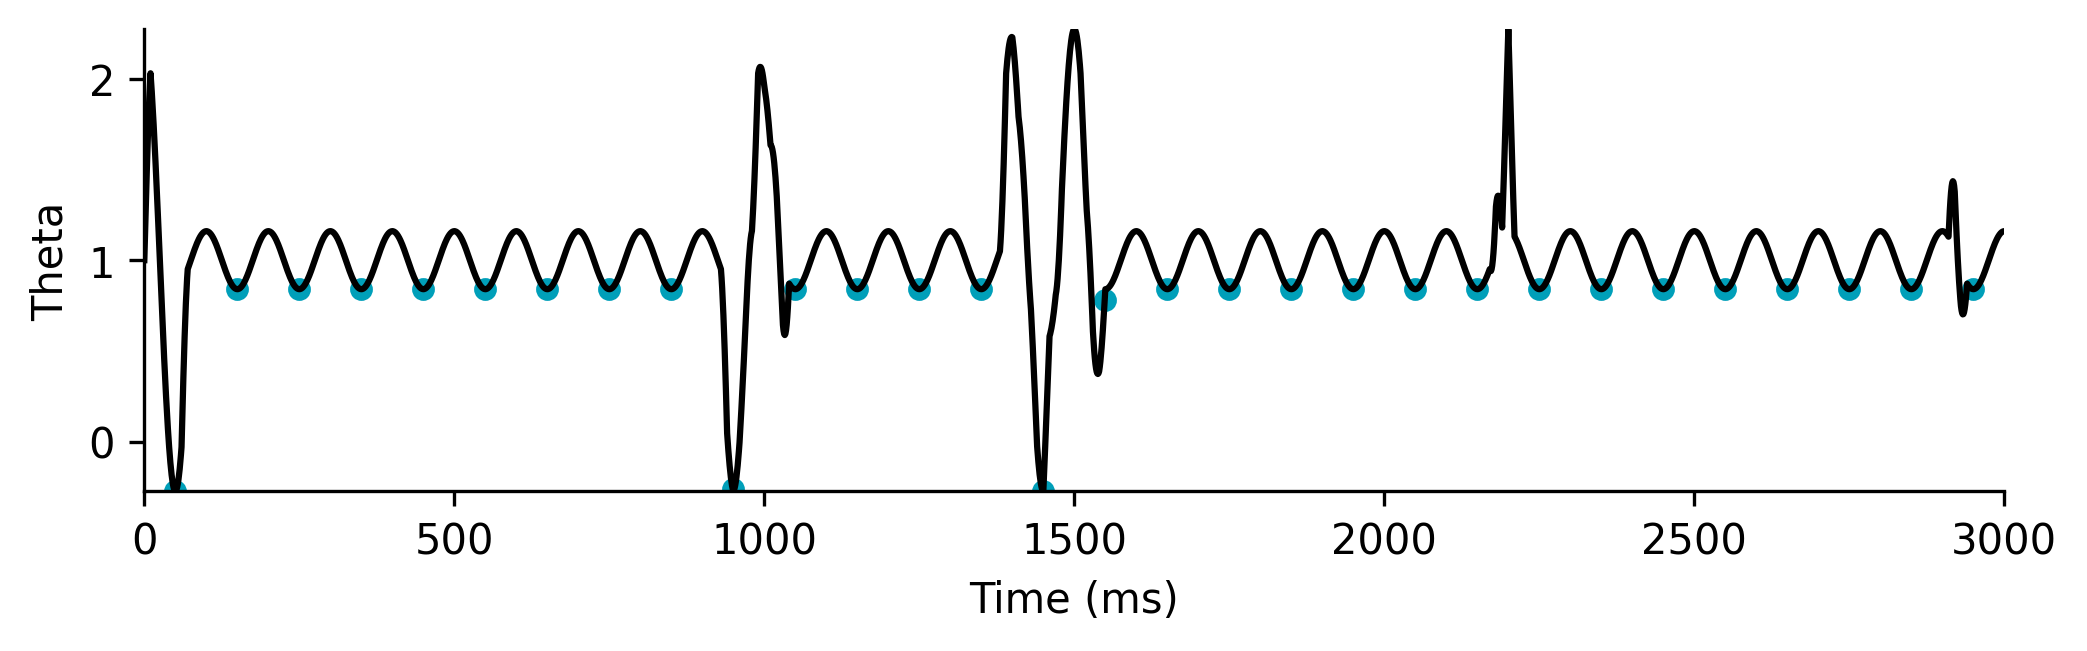

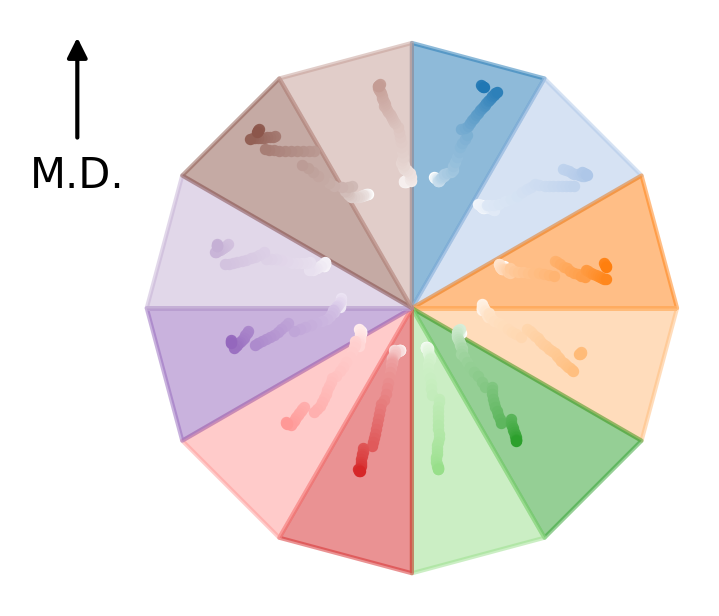

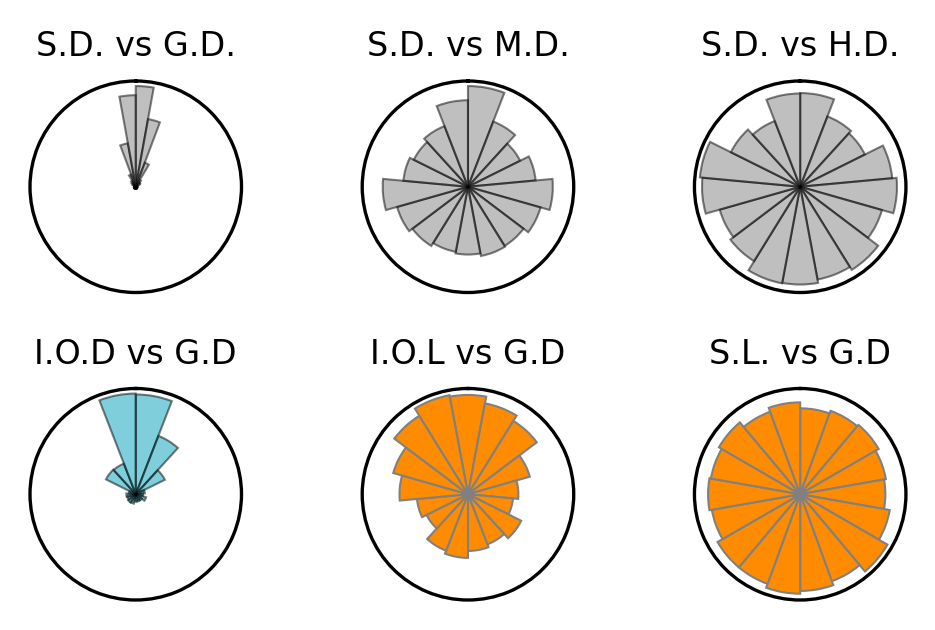

In [9]:
import seaborn as sns
from scipy.signal import find_peaks
from matplotlib.colors import LinearSegmentedColormap

def create_custom_trajectory_cmap(target_color):
    """
    Create a colormap that transitions from white to the target color.

    Parameters
    ----------
    target_color : tuple or str
        A colour accepted by matplotlib (e.g., an RGB/RGBA tuple or a named string)

    Returns
    -------
    LinearSegmentedColormap
        A custom colormap object
    """
    return LinearSegmentedColormap.from_list('custom_cmap', ['white', target_color])


start = 15; end = 65 #extract a middle period as Changmin did in empirical data analysis. He used 15°-195° in 360°, so we used 15-65 in 100. 
num = 50
z_max = np.pi

#find peak using scipy.signal.find_peaks
peaks, _ = find_peaks(theta_phase)
peaks -= 50 #get the trough!!! So that we plot the averaged sweeps like Changmin did in his lateset analysis where he used MUA
# troughs, _ = find_peaks(-theta_phase)       # for minima

#plot theta_rhythm and mark peaks as red dots
# fig, axs = plt.subplots(1, 3, figsize=(10, 3), dpi=100)
#gridspec
fig = plt.figure(figsize=(8, 2), dpi=300)

gs = gridspec.GridSpec(1, 1)

ax = plt.subplot(gs[0])
ax.plot(theta_rhythm, color='black')
ax.scatter(peaks, theta_rhythm[peaks], color='#009FB9', s=20)
# ax.scatter(troughs, theta_rhythm[troughs], color='blue', s=20)
ax.set_xlim(0, 3000)
ax.set_ylim(np.min(theta_rhythm[:3000]), np.max(theta_rhythm[:3000]))
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Theta')
sns.despine()

Angle_at_zeroPhase = []
BumpAngle_2_goal = [] #same dimension as Angle_at_zeroPhase
BumpAngle_2_MD = []
BumpAngle_2_HD = []

BumpAngle_at_all_phase = []
BumpDist_2_pos = []
SweepLength = []
InitOffsetAngle2goal = []
InitOffsetDist = []
InitOffsetAngle2md = []

#at each peak, calculate the angle between moving direction and the vector from the Position to the goal location
for i in range(len(peaks)-1):
    #calculate the vector from the Position to the goal location
    vec = np.array([goal_loc[0] - Animal_location_all[peaks[i], 0], goal_loc[1] - Animal_location_all[peaks[i], 1]])
    #calculate the angle between vec and moving direction
    angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Animal_Vel_all[peaks[i], 1], Animal_Vel_all[peaks[i], 0])
    angle = np.degrees(angle) % 360
    Angle_at_zeroPhase.append(angle)
    
    bumpTraj_in_Acycle = pc_bumpcenter[peaks[i]:peaks[i+1], :]       #/num * z_max
    
    #using 20th point as initial offset
    init_offset_loc = bumpTraj_in_Acycle[start,:]
    #calculate the vect from offset loc to position 
    init_offset_vec = np.array([init_offset_loc[0] - Animal_location_all[peaks[i]+start, 0], init_offset_loc[1] - Animal_location_all[peaks[i]+start, 1]])
    #init offset dist
    int_offset_dist = np.linalg.norm(init_offset_vec)
    InitOffsetDist.append(int_offset_dist)
    
    #calculate the angle between offset_vec and direction to goal
    init_offset_angle = np.arctan2(init_offset_vec[1], init_offset_vec[0]) - np.arctan2(vec[1], vec[0])
    #wrap to 0-360
    init_offset_angle = np.degrees(init_offset_angle) % 360
    #change to radians
    init_offset_angle = np.radians(init_offset_angle)
    #append to InitOffsetAngle2goal
    InitOffsetAngle2goal.append(init_offset_angle)
    
    #calculate the angle between offset_vec and moving direction
    init_offset_angle2md = np.arctan2(init_offset_vec[1], init_offset_vec[0]) - np.arctan2(Animal_Vel_all[peaks[i], 1], Animal_Vel_all[peaks[i], 0])
    #wrap to 0-360
    init_offset_angle2md = np.degrees(init_offset_angle2md) % 360
    #chnage to radians
    init_offset_angle2md = np.radians(init_offset_angle2md)
    InitOffsetAngle2md.append(init_offset_angle2md)    
        
    # sweep_length = np.linalg.norm(bumpTraj_in_Acycle[start,:] - bumpTraj_in_Acycle[end,:])
    # sweep_length = np.linalg.norm(Animal_location_all[peaks[i], :] - bumpTraj_in_Acycle[end,:])
    
    # start_point = bumpTraj_in_Acycle[start, :]
    # # start_point = Animal_location_all[peaks[i], :]
    # distances = np.linalg.norm(bumpTraj_in_Acycle - start_point, axis=1)
    # sweep_length = np.max(distances)

    pos_in_Acycle = Animal_location_all[peaks[i]:peaks[i+1], :]
    # start_point = Animal_location_all[peaks[i], :]
    distances = np.linalg.norm(bumpTraj_in_Acycle - pos_in_Acycle, axis=1)
    sweep_length = np.max(distances) - np.min(distances)  # Calculate the range of distances
    
    SweepLength.append(sweep_length)
    
    BumpAngle = []
    BumpDist = []
    
    # for j in range(len(bumpTraj_in_Acycle)):
    for j in range(start, end):
        pos2goal_vec = np.array([goal_loc[0] - pos_in_Acycle[j, 0], goal_loc[1] - pos_in_Acycle[j, 1]])
        #calculate sweep direction relative to position
        vec2 = np.array([bumpTraj_in_Acycle[j, 0] - pos_in_Acycle[j, 0], bumpTraj_in_Acycle[j, 1] - pos_in_Acycle[j, 1]])
        # Calculate sweep angle relative to goal
        angle2 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(pos2goal_vec[1], pos2goal_vec[0])
        angle2 = np.degrees(angle2) % 360
        angle2 = np.radians(angle2)  # Convert to radians
        BumpAngle_2_goal.append(angle2)
        
        #calculate the angle between sweeps and moving direction
        angle3 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(Animal_Vel_all[peaks[i]+j, 1], Animal_Vel_all[peaks[i]+j, 0])
        angle3 = np.degrees(angle3) % 360
        BumpAngle.append(angle3)
        angle3 = np.radians(angle3)  # Convert to radians
        BumpAngle_2_MD.append(angle3)
        
        #calculate the angle betweens sweeps and head direction
        HD_vec = np.array([np.cos(Head_direction_all[peaks[i]+j]), np.sin(Head_direction_all[peaks[i]+j])])
        angle4 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(HD_vec[1], HD_vec[0])
        angle4 = np.degrees(angle4) % 360
        angle4 = np.radians(angle4)  # Convert to radians
        BumpAngle_2_HD.append(angle4)
        
        #calculate bump distance to the position
        dist = np.linalg.norm(vec2)
        # dist = np.where(dist > 0.5, 1.0 - dist, dist)
        BumpDist.append(dist)
        
    BumpAngle_at_all_phase.append(BumpAngle)
    BumpDist_2_pos.append(BumpDist)

####################################################################################################

fig = plt.figure(figsize=(2.5, 2.5), dpi=300)

gs = gridspec.GridSpec(1, 1)

ax = plt.subplot(gs[0], projection='polar')
#initialize 12 colors from tab20
colors = sns.color_palette("tab20", 12)
#color 1 to 12 rerpesent degree range of 0-30, 30-60, etc

# Shade each sector of the polar plot with the respective color
for i in range(360 // 30):
    ax.fill_between([np.radians(i * 30), np.radians((i + 1) * 30)], 0, 0.8, color=colors[i], alpha=0.5)

scatter_angles = []
scatter_distances = []
scatter_colors = []
scatter_alphas = []

sweep_info = {}

#clasifiy sweeps into 12 bins with 30 degree each
for goal_ang, sweep_angs, sweep_dist in zip(Angle_at_zeroPhase, BumpAngle_at_all_phase, BumpDist_2_pos):
    goal_ang = goal_ang % 360
    indx = int(goal_ang // 30)
    #append sweep_angs and sweep_dist to a dictionary with indx as key
    if indx not in sweep_info:
        sweep_info[indx] = []
    sweep_info[indx].append((sweep_angs, sweep_dist))

#in each angular bin, calculate the mean sweep angle and distance
for key in sweep_info:
    sweep_info_key = sweep_info[key]
    SA = []
    SD = []
    for sweep_angs, sweep_dist in sweep_info_key:
        # SA.append(sweep_angs[start:end])
        # SD.append(sweep_dist[start:end])
        SA.append(sweep_angs)
        SD.append(sweep_dist)        
    #to numpy array using stack
    SA = np.stack(SA)
    SD = np.stack(SD)
    
    # Convert angles in SA to complex numbers
    complex_angles = np.exp(1j * np.radians(SA))  # Convert angles to radians and then to complex form
    mean_complex = np.mean(complex_angles, axis=0)  # Calculate mean in complex plane
    SA_mean = np.degrees(np.angle(mean_complex)) % 360  # Convert back to degrees and wrap to 0-360
    
    # Calculate mean distance
    SD_mean = np.mean(SD, axis=0)
    
    # Get target color
    custom_cmap = create_custom_trajectory_cmap(colors[key])
    n_steps = len(SA_mean)
    gradient_colors = custom_cmap(np.linspace(0.0, 1.0, n_steps) ** 0.8)
    
    for i, (ang, dist) in enumerate(zip(SA_mean, SD_mean)):
        scatter_angles.append(np.radians(ang))
        scatter_distances.append(dist)

        scatter_colors.append(gradient_colors[i])  # white → full colour transition
        scatter_alphas.append(1.0)  # fully opaque

    # Generate gradient colours from white → target_color
    n_steps = len(SA_mean)
    gradient_colors = custom_cmap(np.linspace(0.0, 1.0, n_steps))


#plot mean sweep angle and distance in each angular bin
for i in range(len(scatter_angles)):
    ax.scatter(scatter_angles[i], scatter_distances[i], color=scatter_colors[i], s=3, alpha=scatter_alphas[i])

# Add a black upward arrow labelled "M.D." above the plot
ax.annotate('M.D.',
            xy=(-0.1, 1.0),            # text label (above)
            xytext=(-0.1, 0.7),        # arrow tail (below)
            ha='center', va='bottom',
            fontsize=10,
            arrowprops=dict(arrowstyle='-|>', facecolor='black', lw=1.0),
            xycoords='axes fraction',
            textcoords='axes fraction',
            annotation_clip=False,
            transform=ax.transAxes)

ax.set_yticks([])
# ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticks([])
# ax.set_ylim(0, 0.2)
ax.spines['polar'].set_visible(False)
#plasce 0 at the top
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
#tickfontsize to 6
ax.tick_params(axis='both', which='major', labelsize=6)

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HoneycombSweeps/figures/PaperFig/GDSweeps.pdf', dpi=300)

#-------------------------------Stats--------------------------------

fig = plt.figure(figsize=(3.5, 2.2), dpi=300)

gs = gridspec.GridSpec(2, 3)

#---------------------------S.D. vs G.D.----------------------------

ax0 = plt.subplot(gs[0, 0], projection='polar') 

bins = np.linspace(0, 2*np.pi, 36)
ax0.hist(BumpAngle_2_goal, bins=bins, color='grey', edgecolor='black', linewidth=0.5, alpha=0.5)
ax0.set_title('S.D. vs G.D.', fontsize=8)

#---------------------------S.D. vs M.D.----------------------------

ax1 = plt.subplot(gs[0, 1], projection='polar') 
bins = np.linspace(0, 2*np.pi, 18)
ax1.hist(BumpAngle_2_MD, bins=bins, color='grey', edgecolor='black', linewidth=0.5, alpha=0.5)
ax1.set_title('S.D. vs M.D.', fontsize=8)

#---------------------------S.D. vs H.D.----------------------------

ax2 = plt.subplot(gs[0, 2], projection='polar') 
bins = np.linspace(0, 2*np.pi, 18)
ax2.hist(BumpAngle_2_HD, bins=bins, color='grey', edgecolor='black', linewidth=0.5, alpha=0.5)
ax2.set_title('S.D. vs H.D.', fontsize=8)


#---------------------------I.O.D. vs G.D.----------------------------
ax3 = plt.subplot(gs[1, 0], projection='polar') 
bins = np.linspace(0, 2*np.pi, 18)                                   
ax3.hist(InitOffsetAngle2goal, bins=bins, color='#009FB9', edgecolor='black', linewidth=0.5, alpha=0.5)
ax3.set_title('I.O.D vs G.D', fontsize=8)

#---------------------------I.O.L. vs G.D.----------------------------
ax4 = plt.subplot(gs[1, 1], projection='polar')

bins = np.linspace(0, 2*np.pi, 18)
#calculate the mean distance in each bin
mean_dist = []
for i in range(len(bins)-1):
    indx = np.where((np.array(InitOffsetAngle2md) >= bins[i]) & (np.array(InitOffsetAngle2md) < bins[i+1]))[0]
    if len(indx) > 0:
        mean_dist.append(np.mean(np.array(InitOffsetDist)[indx]))
    else:
        mean_dist.append(0.0)  # Or np.nan if you want to skip this bar later

ax4.bar(bins[:-1], mean_dist, width=bins[1] - bins[0], color='darkorange', edgecolor='grey', linewidth=0.5)


ax4.set_title('I.O.L vs G.D', fontsize=8)

#---------------------------S.L. vs G.D.----------------------------
ax5 = plt.subplot(gs[1, 2], projection='polar') 
ax5.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
# Convert angles to radians in range [0, 2π)
angles_rad = np.radians(np.array(Angle_at_zeroPhase) % 360)
sweep_lengths = np.array(SweepLength)

# Define bin edges (72 bins of 5 degrees)
n_bins = 18
bin_edges = np.linspace(0, 2 * np.pi, n_bins + 1)

# Digitise the angle data into bins
bin_indices = np.digitize(angles_rad, bin_edges) - 1  # subtract 1 to make indices 0-based

# Initialise array to store average sweep lengths
avg_sweep_length = np.zeros(n_bins)
for i in range(n_bins):
    in_bin = sweep_lengths[bin_indices == i]
    if len(in_bin) > 0:
        avg_sweep_length[i] = np.mean(in_bin)
    else:
        avg_sweep_length[i] = 0.0  # or np.nan if you prefer

# Prepare angles for bar centres
bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot as polar histogram (bar plot)
ax5.bar(bin_centres, avg_sweep_length, width=(2 * np.pi / n_bins), bottom=0.0, color='darkorange', edgecolor='grey', linewidth=0.5)

ax5.set_title('S.L. vs G.D', fontsize=8)


for ax in [ax0, ax1, ax2, ax3, ax4, ax5]:
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_yticks([])
    # ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
    ax.set_xticks([])
    ax.tick_params(axis='both', which='major', labelsize=6)

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HoneycombSweeps/figures/PaperFig/Sweeps_Stats.pdf', dpi=300)

## Section 5: Check theta phase precession relative to distance to goal

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def find_periods(Position, goal_loc, threshold=1000):
    """
    Finds continuous periods where the distance to goal_loc is either decreasing or increasing 
    for at least `threshold` points.

    Parameters:
    - Position (ndarray): Array of positions (Nx2 or Nx3 for 2D or 3D positions).
    - goal_loc (ndarray): Goal location as an array (2D or 3D).
    - threshold (int): Minimum length of a continuous period to consider.

    Returns:
    - decreasing_periods (list): List of tuples (start_index, end_index) for valid decreasing periods.
    - increasing_periods (list): List of tuples (start_index, end_index) for valid increasing periods.
    """
    decreasing_periods = []
    increasing_periods = []
    current_start = None
    decreasing_count = 0
    increasing_count = 0
    mode = None  # Tracks whether we're in a decreasing or increasing phase

    for i in range(1, len(Position)):
        dist_prev = np.linalg.norm(Position[i-1] - goal_loc)
        dist_curr = np.linalg.norm(Position[i] - goal_loc)

        if dist_curr < dist_prev:  # Distance is decreasing
            if mode != "decreasing":
                # End previous increasing period
                if increasing_count >= threshold:
                    increasing_periods.append((current_start, current_start + increasing_count))
                current_start = i - 1
                increasing_count = 0
                mode = "decreasing"
            decreasing_count += 1
        elif dist_curr > dist_prev:  # Distance is increasing
            if mode != "increasing":
                # End previous decreasing period
                if decreasing_count >= threshold:
                    decreasing_periods.append((current_start, current_start + decreasing_count))
                current_start = i - 1
                decreasing_count = 0
                mode = "increasing"
            increasing_count += 1
        else:
            # Distance is constant or ambiguous, reset counters and handle ending periods
            if mode == "decreasing" and decreasing_count >= threshold:
                decreasing_periods.append((current_start, current_start + decreasing_count))
            elif mode == "increasing" and increasing_count >= threshold:
                increasing_periods.append((current_start, current_start + increasing_count))
            current_start = None
            decreasing_count = 0
            increasing_count = 0
            mode = None

    # Final check after the loop ends
    if mode == "decreasing" and decreasing_count >= threshold:
        decreasing_periods.append((current_start, current_start + decreasing_count))
    elif mode == "increasing" and increasing_count >= threshold:
        increasing_periods.append((current_start, current_start + increasing_count))

    return decreasing_periods, increasing_periods


def restrict_periods_to_field(periods, positions, cx, cy, radius, min_length=10):
    """
    From each (start, end) period, extract all subsegments where position stays inside circle.

    Parameters
    ----------
    periods : list of (start, end)
    positions : (N, 2) array
    cx, cy : float
        Centre of the circle
    radius : float
        Radius of the field
    min_length : int
        Minimum duration (in samples) for a subperiod to keep

    Returns
    -------
    restricted_periods : list of (sub_start, sub_end)
    """
    restricted = []

    for start, end in periods:
        segment = positions[start:end+1]
        dists = np.sqrt((segment[:, 0] - cx) ** 2 + (segment[:, 1] - cy) ** 2)
        inside = dists <= radius

        # Find continuous chunks where inside == True
        i = 0
        while i < len(inside):
            if inside[i]:
                sub_start = i
                while i < len(inside) and inside[i]:
                    i += 1
                sub_end = i - 1
                if (sub_end - sub_start + 1) >= min_length:
                    restricted.append((start + sub_start, start + sub_end))
            else:
                i += 1

    return restricted




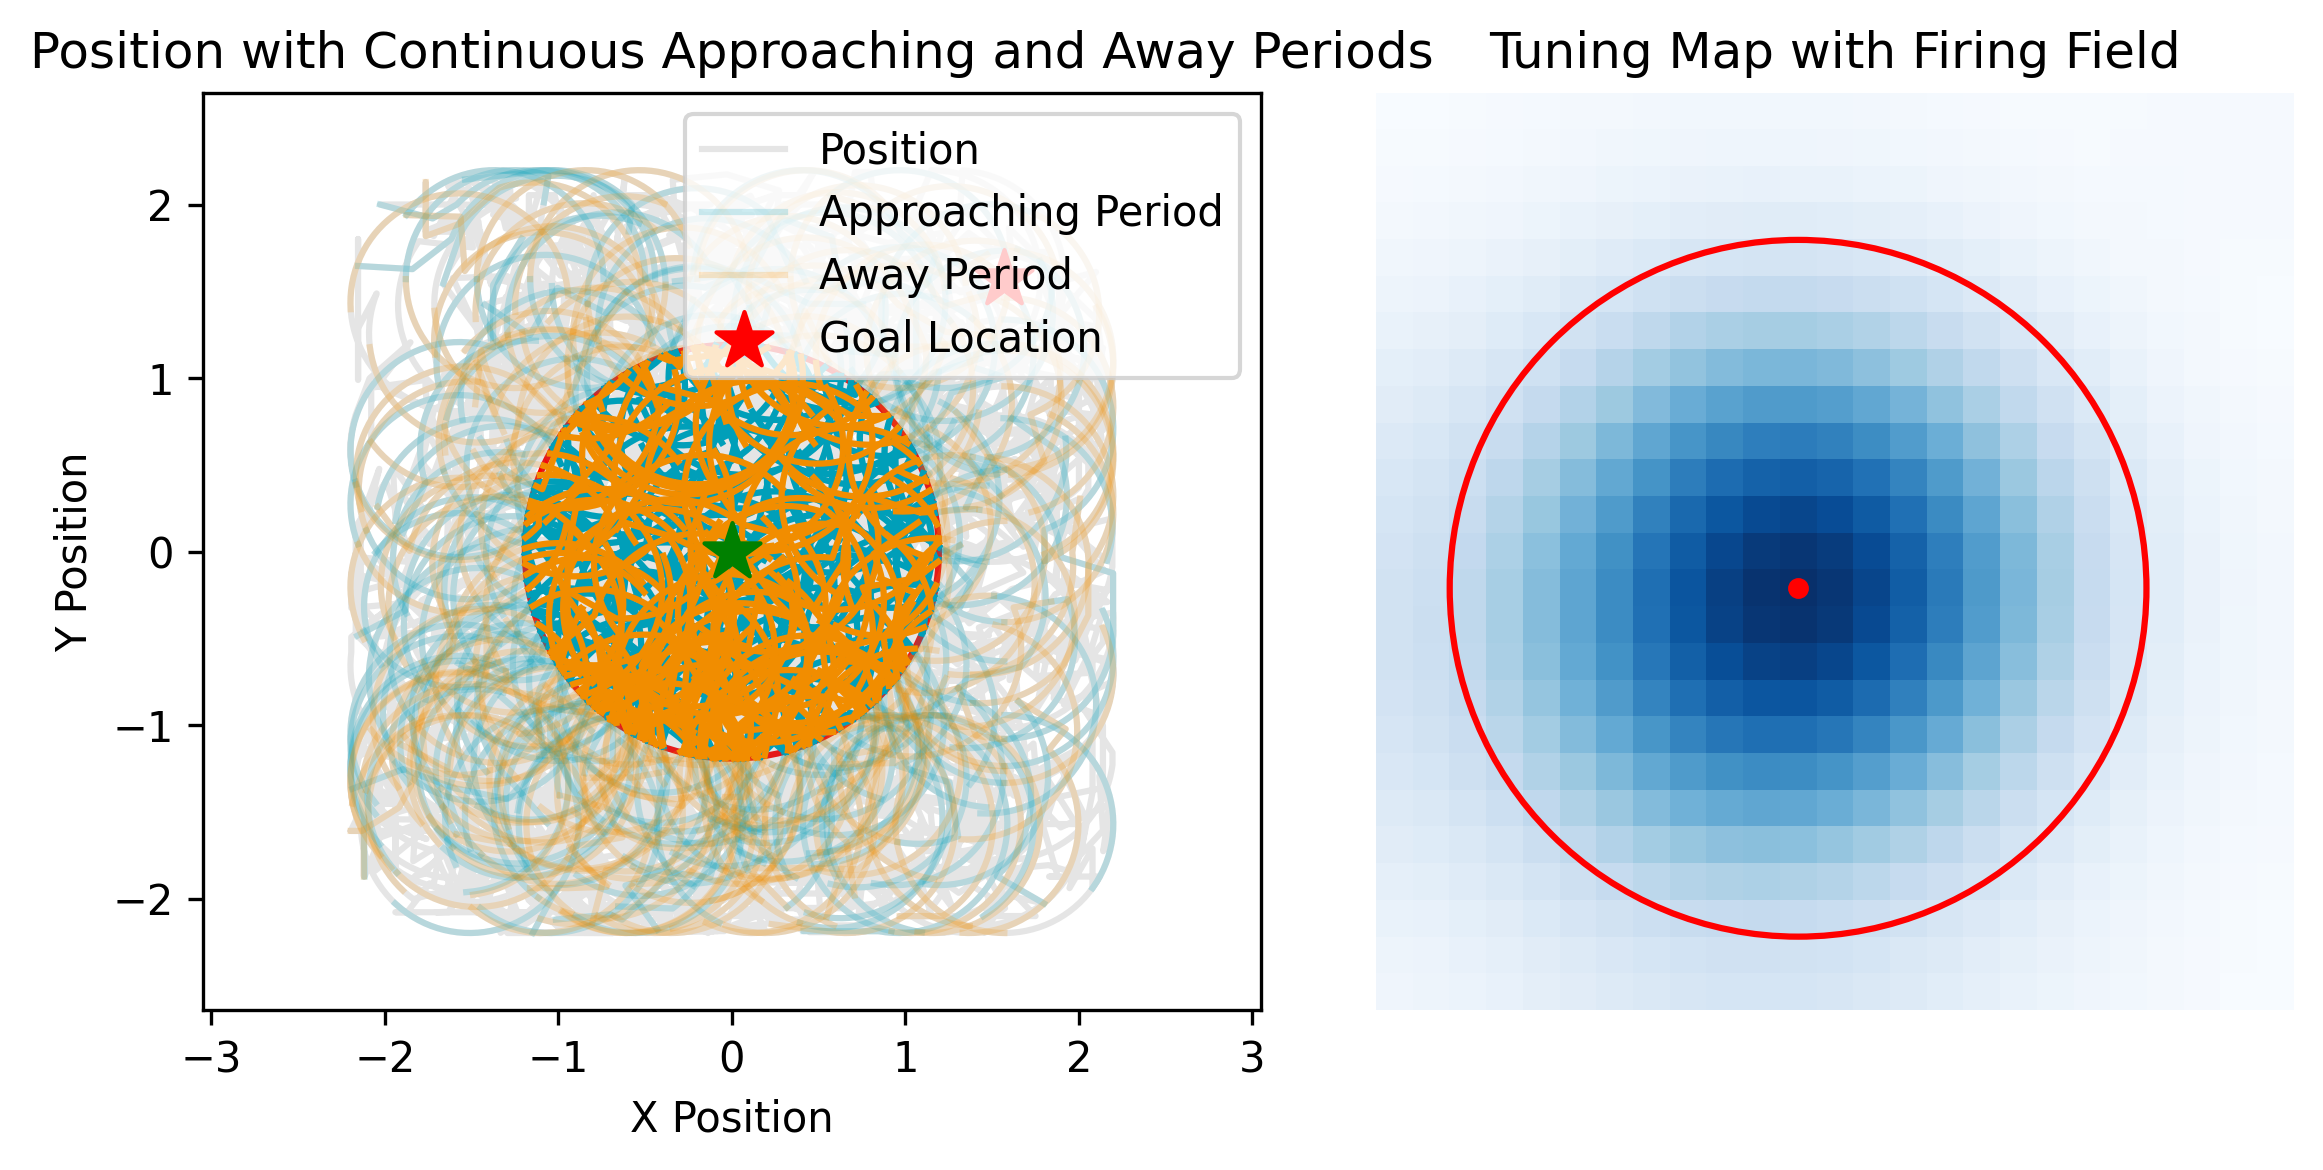

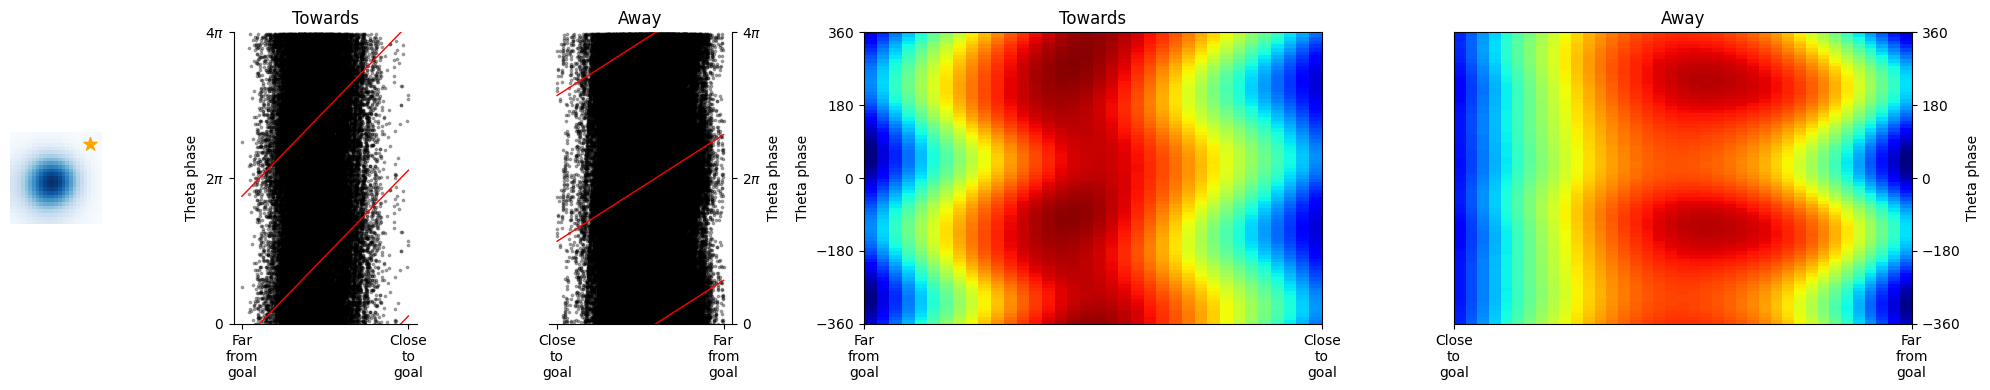

In [11]:
# Example usage:
decreasing_periods, increasing_periods = find_periods(Animal_location_all, goal_loc, threshold=300)

fig, axs = plt.subplots(1,2,figsize=(8, 4), dpi=300)

ax = axs[0]
# Plot all positions in grey
ax.plot(Animal_location_all[:, 0], Animal_location_all[:, 1], color='grey', label='Position', alpha = 0.2)

# Highlight decreasing (approaching) periods in blue
for start, end in decreasing_periods:
    ax.plot(
        Animal_location_all[start:end+1, 0],
        Animal_location_all[start:end+1, 1],
        color='#009FB9',
        label='Approaching Period' if start == decreasing_periods[0][0] else "",
        alpha = 0.2
    )

# Highlight increasing (away) periods in orange
for start, end in increasing_periods:
    ax.plot(
        Animal_location_all[start:end+1, 0],
        Animal_location_all[start:end+1, 1],
        color='#F18D00',
        label='Away Period' if start == increasing_periods[0][0] else "",
        alpha = 0.2
    )

# Mark goal location
ax.scatter(goal_loc[0], goal_loc[1], color='red', marker='*', label='Goal Location', zorder=5, s=200)

# Formatting
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Position with Continuous Approaching and Away Periods')
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)
ax.legend()
ax.axis('equal')

ax = axs[1]

cellindex = [25, 25]

#tuning map of a cell

Position_norm = (Animal_location_all - Animal_location_all.min() - 1e-5)/(Animal_location_all.max() - Animal_location_all.min())
dim = num//2
tuningMap = get_tuningMap(pc_activity, 
                          Position_norm, 
                          cellindex_x=cellindex[0],
                          cellindex_y=cellindex[1],
                          filter=True,
                          samples_per_sec=1000,
                          dim=dim)
ax.imshow(tuningMap, cmap='Blues', origin='lower')

# Smooth the tuning map if needed
tuningMap_smooth = gaussian_filter(tuningMap, sigma=1)

# Get peak location
peak_y, peak_x = np.unravel_index(np.nanargmax(tuningMap_smooth), tuningMap.shape)

# Compute radius based on 30% peak
threshold = 0.02 * np.nanmax(tuningMap_smooth)
mask = tuningMap_smooth >= threshold
y_idx, x_idx = np.where(mask)
distances = np.sqrt((x_idx - peak_x)**2 + (y_idx - peak_y)**2)
mean_radius = np.mean(distances)

# Plot on axs[1]
axs[1].imshow(tuningMap_smooth, cmap='Blues', origin='lower')
circle = plt.Circle((peak_x, peak_y), mean_radius, color='red', fill=False, linewidth=1.5)
axs[1].add_patch(circle)
axs[1].plot(peak_x, peak_y, 'ro', markersize=4)
axs[1].set_title('Tuning Map with Firing Field')
axs[1].axis('off')


#add this cycle to ax[0], center is x = cellindex[0]/50*2*np.pi-np.pi, y = cellindex[1]/50*2*np.pi-np.pi
cx = cellindex[0]/50*2*np.pi-np.pi
cy = cellindex[1]/50*2*np.pi-np.pi
axs[0].scatter(cx, cy, color='green', marker='*', label='Field center', zorder=5, s=200)
real_radius = mean_radius/num*2*np.pi
circle = plt.Circle((cx, cy), real_radius, color='red', fill=False, linewidth=1.5)
axs[0].add_patch(circle)

# Apply restriction using computed circle
decreasing_periods_field = restrict_periods_to_field(decreasing_periods, Animal_location_all, cx, cy, real_radius)
increasing_periods_field = restrict_periods_to_field(increasing_periods, Animal_location_all, cx, cy, real_radius)

# Highlight decreasing (approaching) periods in blue
for start, end in decreasing_periods_field:
    axs[0].plot(
        Animal_location_all[start:end+1, 0],
        Animal_location_all[start:end+1, 1],
        color='#009FB9',
        label='Towards' if start == decreasing_periods_field[0][0] else "",
        alpha = 1.0
    )

# Highlight increasing (away) periods in orange
for start, end in increasing_periods_field:
    axs[0].plot(
        Animal_location_all[start:end+1, 0],
        Animal_location_all[start:end+1, 1],
        color='#F18D00',
        label='Away' if start == increasing_periods_field[0][0] else "",
        alpha = 1.0
    )





plt.tight_layout()
plt.show()



########################################################
########################################################
########################################################
########################################################




# variable needed: cellindex, pc_activity, Position, goal_loc, theta_phase
# np.random.seed(11)   
dt = 0.001
addfitline = True

#------------------------------- ------------------------------------- --------------------------------- ------------------------------------      

fig = plt.figure(figsize=(20,4), dpi=100)
gs = gridspec.GridSpec(1, 5, width_ratios=[1,2,2,5,5])


ax = plt.subplot(gs[0])
#tuning map of a cell

Position_norm = (Animal_location_all - Animal_location_all.min() - 1e-5)/(Animal_location_all.max() - Animal_location_all.min())
dim = num//2
tuningMap = get_tuningMap(pc_activity, 
                          Position_norm, 
                          cellindex_x=cellindex[0],
                          cellindex_y=cellindex[1],
                          filter=True,
                          samples_per_sec=1000,
                          dim=dim)
ax.imshow(tuningMap, cmap='Blues', origin='lower')



#mark the goal location
goal_x = (goal_loc[0]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*dim
goal_y = (goal_loc[1]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*dim

ax.scatter(goal_x, goal_y, color='Orange', marker='*', s=100)

ax.axis('off')


####################################################################################################

#Phase against distance to goal

ax = plt.subplot(gs[1])
Dist2G = []
SpikePhase = []
RelativeDirection = []

r = pc_activity[:, cellindex[0], cellindex[1]] * 1 #ms to s

for start, end in decreasing_periods:
    for i in range(start, end):
        #get the distance to goal_loc
        dist_i = np.linalg.norm(Animal_location_all[i] - goal_loc)
        
        # dist_i = np.linalg.norm(Animal_location_all[i,:]-Animal_location_all[start,:]) / np.linalg.norm(Animal_location_all[end,:]-Animal_location_all[start,:])
        
        
        #get the vec pointing from Position to goal_loc
        vec = goal_loc - Animal_location_all[i]
        #get the angle between vec and moving direction
        angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Animal_Vel_all[i, 1], Animal_Vel_all[i, 0])
        angle = np.degrees(angle) % 360

        #get the phase at current time step i
        phase_i = theta_phase[i]*np.pi*2

        spikes = np.random.poisson(r[i]*dt*200)
        if spikes > 0:
            #save dist_i and phase_i
            Dist2G.append(dist_i)
            SpikePhase.append(phase_i)
            RelativeDirection.append(angle)


Dist2G = np.asarray(Dist2G)
SpikePhase = np.asarray(SpikePhase)

ax.scatter(Dist2G, SpikePhase, s=3, color='black', alpha=0.3)

ax.scatter(Dist2G, SpikePhase+2*np.pi, s=3, color='black', alpha=0.3)
# Create a 2D histogram for heat map

circ_lin_corr, pval, slope, phi0, RR = cl_corr(Dist2G, SpikePhase, min_slope=-2, max_slope=2, bootstrap_iter=3000, return_pval=True)

if addfitline:
    # Plot the circular-linear regression
    x = np.linspace(Dist2G.min(), Dist2G.max(), 100)
    y = 2 * np.pi * slope * x + phi0
    ax.plot(x, y, color='red', linewidth=1)
    #add intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
    ax.plot(x, y, color='red', linewidth=1)
    #add intercepr of 4*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
    ax.plot(x, y, color='red', linewidth=1)
    #substrac intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
    ax.plot(x, y, color='red', linewidth=1)  

#flip x axis with small values on the right and large values on the left
# Flip the x-axis
ax.invert_xaxis()

# ax.set_xlim(0, 1)
ax.set_xticks([Dist2G.min(), Dist2G.max()])
ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'])

# ax[0].set_xlabel('Head direction')
# ax.set_xlabel('Dist2Goal', fontsize=10)
ax.set_ylabel('Theta phase', fontsize=10)
# #activity colorba
ax.set_ylim(0, 4*np.pi)
ax.set_yticks([0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])   
ax.set_title('Towards')

sns.despine()


####################################################################################################
ax = plt.subplot(gs[3])

# Wrap phase by duplicating with +2π to handle circularity
SpikePhase_wrapped = np.concatenate([SpikePhase, SpikePhase + 2 * np.pi, SpikePhase + 4*np.pi]) 
Dist2G_wrapped = np.concatenate([Dist2G, Dist2G, Dist2G])
# Compute 2D histogram
n_bins = 120
heatmap, xedges, yedges = np.histogram2d(Dist2G_wrapped, SpikePhase_wrapped, bins=[n_bins, n_bins])
# Smooth with Gaussian filter
heatmap_smooth = gaussian_filter(heatmap, sigma=5)

sum_heatmap = np.sum(heatmap_smooth, axis=1)
valid_x_indices = sum_heatmap > 0.6 * np.max(sum_heatmap)
# Apply column filter
heatmap_smooth_4_plot = heatmap_smooth[valid_x_indices, :]

# Adjust xedges and X accordingly
xedges_filtered = xedges[:-1][valid_x_indices]  # remove last bin edge, select valid
xedges_filtered = np.append(xedges_filtered, xedges_filtered[-1] + np.diff(xedges).mean())  # match dimension

# Create matching meshgrid
X, Y = np.meshgrid(xedges_filtered, yedges)

# Plot
pcm = ax.pcolormesh(X, Y, heatmap_smooth_4_plot.T, shading='auto', cmap='jet')

#flip x axis with small values on the right and large values on the left
# Flip the x-axis
ax.invert_xaxis()

ax.set_xticks([xedges_filtered.min(), xedges_filtered.max()])
ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'])

ax.set_ylabel('Theta phase', fontsize=10)
# #activity colorba
ax.set_ylim(np.pi, 5*np.pi) #start from np.pi since we want to make MUA trough as 0 degree, previous is 180 degree
ax.set_yticks([np.pi, 2*np.pi, 3*np.pi, 4*np.pi, 5*np.pi])
ax.set_yticklabels([r'$-360$', r'$-180$', r'$0$', r'$180$', r'$360$'])   
ax.set_title('Towards')

####################################################################################################

ax = plt.subplot(gs[2])
Dist2G = []
SpikePhase = []
RelativeDirection = []

r = pc_activity[:, cellindex[0], cellindex[1]] * 1 #ms to s

for start, end in increasing_periods:
    for i in range(start, end):
        #get the distance to goal_loc
        dist_i = np.linalg.norm(Animal_location_all[i] - goal_loc)
        # dist_i = np.linalg.norm(Animal_location_all[i,:]-Animal_location_all[start,:]) / np.linalg.norm(Animal_location_all[end,:]-Animal_location_all[start,:])
        
        #get the vec pointing from Position to goal_loc
        vec = goal_loc - Animal_location_all[i]
        #get the angle between vec and moving direction
        angle = np.arctan2(vec[1], vec[0]) - np.arctan2(Animal_Vel_all[i, 1], Animal_Vel_all[i, 0])
        angle = np.degrees(angle) % 360

        #get the phase at current time step i
        phase_i = theta_phase[i]*np.pi*2

        spikes = np.random.poisson(r[i]*dt*1000)
        if spikes > 0:
            #save dist_i and phase_i
            Dist2G.append(dist_i)
            SpikePhase.append(phase_i)
            RelativeDirection.append(angle)


Dist2G = np.asarray(Dist2G)
SpikePhase = np.asarray(SpikePhase)

ax.scatter(Dist2G, SpikePhase, s=3, color='black', alpha=0.3)

ax.scatter(Dist2G, SpikePhase+2*np.pi, s=3, color='black', alpha=0.3)

circ_lin_corr, pval, slope, phi0, RR = cl_corr(Dist2G, SpikePhase, min_slope=-2, max_slope=2, bootstrap_iter=3000, return_pval=True)

if addfitline:
    # Plot the circular-linear regression
    x = np.linspace(Dist2G.min(), Dist2G.max(), 100)
    y = 2 * np.pi * slope * x + phi0
    ax.plot(x, y, color='red', linewidth=1)
    #add intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
    ax.plot(x, y, color='red', linewidth=1)
    #add intercepr of 4*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
    ax.plot(x, y, color='red', linewidth=1)
    #substrac intercepr of 2*pi, and plot the line again
    y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
    ax.plot(x, y, color='red', linewidth=1)  

# ax.set_xlim(0, 1)
ax.set_xticks([Dist2G.min(), Dist2G.max()])
ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'])
# ax[0].set_xlabel('Head direction')
# ax.set_xlabel('Dist2Goal', fontsize=10)
#show y axis, ticks labels on the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
    
ax.set_ylabel('Theta phase', fontsize=10)
ax.set_ylim(0, 4*np.pi)
ax.set_yticks([0, 2*np.pi, 4*np.pi])
ax.set_yticklabels([r'$0$', r'$2\pi$', r'$4\pi$'])   
ax.set_title('Away')

#despine the left and top
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)


####################################################################################################
ax = plt.subplot(gs[4])

# Wrap phase by duplicating with +2π to handle circularity
SpikePhase_wrapped = np.concatenate([SpikePhase, SpikePhase + 2 * np.pi, SpikePhase + 4*np.pi]) 
Dist2G_wrapped = np.concatenate([Dist2G, Dist2G, Dist2G])
# Compute 2D histogram
n_bins = 120
heatmap, xedges, yedges = np.histogram2d(Dist2G_wrapped, SpikePhase_wrapped, bins=[n_bins, n_bins])
# Smooth with Gaussian filter
heatmap_smooth = gaussian_filter(heatmap, sigma=5)

sum_heatmap = np.sum(heatmap_smooth, axis=1)
valid_x_indices = sum_heatmap > 0.6 * np.max(sum_heatmap)
# Apply column filter
heatmap_smooth_4_plot = heatmap_smooth[valid_x_indices, :]

# Adjust xedges and X accordingly
xedges_filtered = xedges[:-1][valid_x_indices]  # remove last bin edge, select valid
xedges_filtered = np.append(xedges_filtered, xedges_filtered[-1] + np.diff(xedges).mean())  # match dimension

# Create matching meshgrid
X, Y = np.meshgrid(xedges_filtered, yedges)

# Plot
pcm = ax.pcolormesh(X, Y, heatmap_smooth_4_plot.T, shading='auto', cmap='jet')

# ax.set_xlim(0, 1)
ax.set_xticks([xedges_filtered.min(), xedges_filtered.max()])
ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'])
# ax[0].set_xlabel('Head direction')
# ax.set_xlabel('Dist2Goal', fontsize=10)
#show y axis, ticks labels on the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
    
ax.set_ylabel('Theta phase', fontsize=10)
ax.set_ylim(np.pi, 5*np.pi)  #start from np.pi since we want to make MUA trough as 0 degree, previous is 180 degree
ax.set_yticks([np.pi, 2*np.pi, 3*np.pi, 4*np.pi, 5*np.pi])
ax.set_yticklabels([r'$-360$', r'$-180$', r'$0$', r'$180$', r'$360$'])   
ax.set_title('Away')

####################################################################################################


plt.tight_layout()


### produce phase precession for paper figures


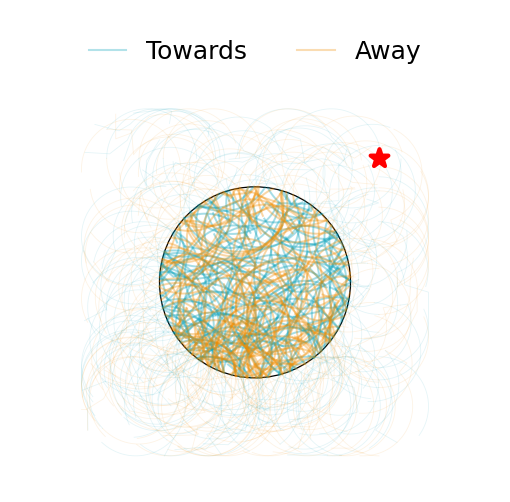

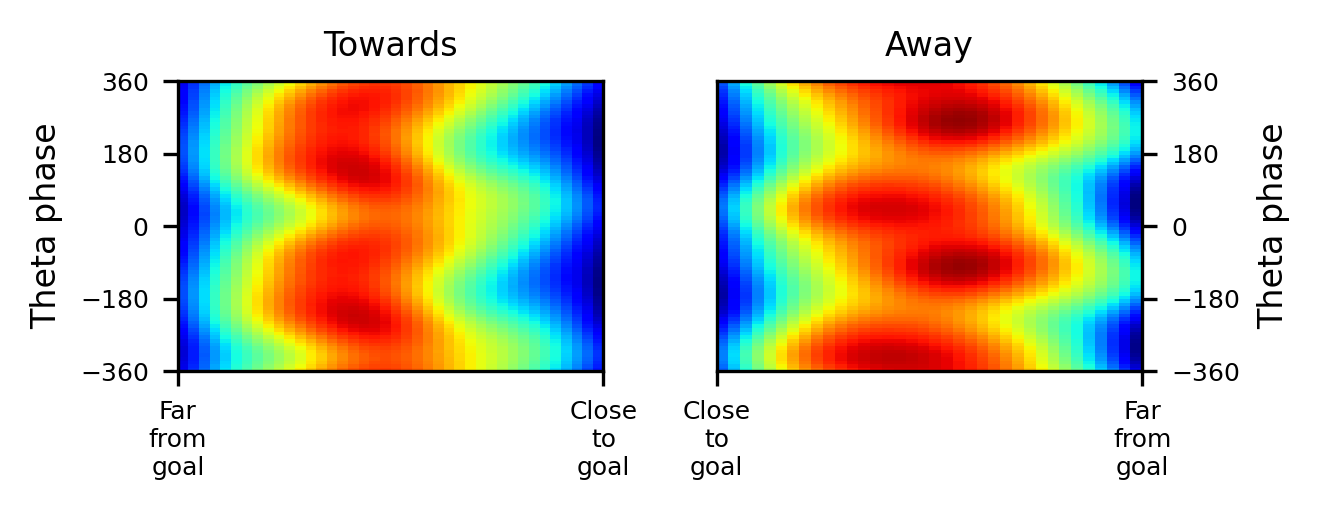

In [69]:
cellindex = [25, 25]

# Example usage:
decreasing_periods, increasing_periods = find_periods(Animal_location_all, goal_loc, threshold=300)

fig, ax = plt.subplots(1,1,figsize=(1.8, 1.8), dpi=300)

# Highlight decreasing (approaching) periods in blue
for start, end in decreasing_periods:
    ax.plot(
        Animal_location_all[start:end+1, 0],
        Animal_location_all[start:end+1, 1],
        color='#009FB9',
        alpha = 0.1,
        linewidth=0.2
    )

# Highlight increasing (away) periods in orange
for start, end in increasing_periods:
    ax.plot(
        Animal_location_all[start:end+1, 0],
        Animal_location_all[start:end+1, 1],
        color='#F18D00',
        alpha = 0.1,
        linewidth=0.2
    )

# Mark goal location
ax.scatter(goal_loc[0], goal_loc[1], color='red', marker='*', zorder=5, s=20)

#tuning map of a cell

Position_norm = (Animal_location_all - Animal_location_all.min() - 1e-5)/(Animal_location_all.max() - Animal_location_all.min())
dim = num//2
tuningMap = get_tuningMap(pc_activity, 
                          Position_norm, 
                          cellindex_x=cellindex[0],
                          cellindex_y=cellindex[1],
                          filter=True,
                          samples_per_sec=1000,
                          dim=dim)

# Smooth the tuning map if needed
tuningMap_smooth = gaussian_filter(tuningMap, sigma=1)

# Get peak location
peak_y, peak_x = np.unravel_index(np.nanargmax(tuningMap_smooth), tuningMap.shape)

# Compute radius based on 30% peak
threshold = 0.001 * np.nanmax(tuningMap_smooth)
mask = tuningMap_smooth >= threshold
y_idx, x_idx = np.where(mask)
distances = np.sqrt((x_idx - peak_x)**2 + (y_idx - peak_y)**2)
mean_radius = np.mean(distances)


#add this cycle to ax[0], center is x = cellindex[0]/50*2*np.pi-np.pi, y = cellindex[1]/50*2*np.pi-np.pi
cx = cellindex[0]/50*2*np.pi-np.pi
cy = cellindex[1]/50*2*np.pi-np.pi
# ax.scatter(cx, cy, color='green', marker='*', label='Field center', zorder=5, s=200)
real_radius = mean_radius/num*2*np.pi
circle = plt.Circle((cx, cy), real_radius, color='black', fill=False, linewidth=0.3)
ax.add_patch(circle)

# Apply restriction using computed circle
decreasing_periods_field = restrict_periods_to_field(decreasing_periods, Animal_location_all, cx, cy, real_radius)
increasing_periods_field = restrict_periods_to_field(increasing_periods, Animal_location_all, cx, cy, real_radius)

# Highlight decreasing (approaching) periods in blue
for start, end in decreasing_periods_field:
    ax.plot(
        Animal_location_all[start:end+1, 0],
        Animal_location_all[start:end+1, 1],
        color='#009FB9',
        label='Towards' if start == decreasing_periods_field[0][0] else "",
        alpha = 0.3,
        linewidth=0.5
    )

# Highlight increasing (away) periods in orange
for start, end in increasing_periods_field:
    ax.plot(
        Animal_location_all[start:end+1, 0],
        Animal_location_all[start:end+1, 1],
        color='#F18D00',
        label='Away' if start == increasing_periods_field[0][0] else "",
        alpha = 0.3,
        linewidth=0.5
    )
    
# Formatting
ax.axis('equal')
#remove axis
ax.axis('off')
    
ax.legend( loc='upper center', fontsize=6, markerscale=2, frameon=False, handlelength=1.5, bbox_to_anchor=(0.5, 1.2), ncol=2)


plt.tight_layout()


########################################################
########################################################
########################################################
########################################################




# variable needed: cellindex, pc_activity, Position, goal_loc, theta_phase
# np.random.seed(11)   
dt = 0.001

#------------------------------- ------------------------------------- --------------------------------- ------------------------------------      

fig = plt.figure(figsize=(4.5,1.8), dpi=300)
gs = gridspec.GridSpec(1, 2)

n_bins = 120

####################################################################################################

#Phase against distance to goal (Towards periods)

Dist2G = []
SpikePhase = []
r = pc_activity[:, cellindex[0], cellindex[1]]

spikes = np.random.poisson(r/20)  #/20 since if not, will generate lots of fake spikes I think

for start, end in decreasing_periods:
    for i in range(start, end):
        #get the distance to goal_loc
        dist_i = np.linalg.norm(Animal_location_all[i] - goal_loc)
        #get the phase at current time step i
        phase_i = theta_phase[i]*np.pi*2

        spike = spikes[i]
        if spike > 0:
            #save dist_i and phase_i
            Dist2G.append(dist_i)
            SpikePhase.append(phase_i)

Dist2G = np.asarray(Dist2G)
#normalize Dist2G to [0, 1]
Dist2G = (Dist2G - Dist2G.min()) / (Dist2G.max() - Dist2G.min())
SpikePhase = np.asarray(SpikePhase)

ax = plt.subplot(gs[0])

# Wrap phase by duplicating with +2π to handle circularity
SpikePhase_wrapped = np.concatenate([SpikePhase, SpikePhase + 2 * np.pi, SpikePhase + 4*np.pi]) 
Dist2G_wrapped = np.concatenate([Dist2G, Dist2G, Dist2G])
# Compute 2D histogram
heatmap, xedges, yedges = np.histogram2d(Dist2G_wrapped, SpikePhase_wrapped, bins=[n_bins, n_bins])
# Smooth with Gaussian filter
heatmap_smooth = gaussian_filter(heatmap, sigma=5)

sum_heatmap = np.sum(heatmap_smooth, axis=1)
valid_x_indices = sum_heatmap > 0.6 * np.max(sum_heatmap)
# Apply column filter
heatmap_smooth_4_plot = heatmap_smooth[valid_x_indices, :]

# Adjust xedges and X accordingly
xedges_filtered = xedges[:-1][valid_x_indices]  # remove last bin edge, select valid
xedges_filtered = np.append(xedges_filtered, xedges_filtered[-1] + np.diff(xedges).mean())  # match dimension

# Create matching meshgrid
X, Y = np.meshgrid(xedges_filtered, yedges)

# Plot
pcm = ax.pcolormesh(X, Y, heatmap_smooth_4_plot.T, shading='auto', cmap='jet')

#!!!! flip x axis with small values on the right and large values on the left
# Flip the x-axis
ax.invert_xaxis()

ax.set_xticks([xedges_filtered.min(), xedges_filtered.max()])
ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'])

ax.set_ylabel('Theta phase', fontsize=8)
# #activity colorba
ax.set_ylim(np.pi, 5*np.pi) #start from np.pi since we want to make MUA trough as 0 degree, previous is 180 degree
ax.set_yticks([np.pi, 2*np.pi, 3*np.pi, 4*np.pi, 5*np.pi])
ax.set_yticklabels([r'$-360$', r'$-180$', r'$0$', r'$180$', r'$360$'])   
ax.set_title('Towards', fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=6)


#------------------------------- ------------------------------------- --------------------------------- ------------------------------------      

Dist2G = []
SpikePhase = []

for start, end in increasing_periods:
    for i in range(start, end):
        #get the distance to goal_loc
        dist_i = np.linalg.norm(Animal_location_all[i] - goal_loc)
        #get the phase at current time step i
        phase_i = theta_phase[i]*np.pi*2
        spike = spikes[i]
        if spike > 0:
            #save dist_i and phase_i
            Dist2G.append(dist_i)
            SpikePhase.append(phase_i)

Dist2G = np.asarray(Dist2G)
#normalize Dist2G to [0, 1]
Dist2G = (Dist2G - Dist2G.min()) / (Dist2G.max() - Dist2G.min())
SpikePhase = np.asarray(SpikePhase)


ax = plt.subplot(gs[1])

# Wrap phase by duplicating with +2π to handle circularity
SpikePhase_wrapped = np.concatenate([SpikePhase, SpikePhase + 2 * np.pi, SpikePhase + 4*np.pi]) 
Dist2G_wrapped = np.concatenate([Dist2G, Dist2G, Dist2G])
# Compute 2D histogram
heatmap, xedges, yedges = np.histogram2d(Dist2G_wrapped, SpikePhase_wrapped, bins=[n_bins, n_bins])
# Smooth with Gaussian filter
heatmap_smooth = gaussian_filter(heatmap, sigma=5)

sum_heatmap = np.sum(heatmap_smooth, axis=1)
valid_x_indices = sum_heatmap > 0.6 * np.max(sum_heatmap)
# Apply column filter
heatmap_smooth_4_plot = heatmap_smooth[valid_x_indices, :]

# Adjust xedges and X accordingly
xedges_filtered = xedges[:-1][valid_x_indices]  # remove last bin edge, select valid
xedges_filtered = np.append(xedges_filtered, xedges_filtered[-1] + np.diff(xedges).mean())  # match dimension

# Create matching meshgrid
X, Y = np.meshgrid(xedges_filtered, yedges)

# Plot
pcm = ax.pcolormesh(X, Y, heatmap_smooth_4_plot.T, shading='auto', cmap='jet')

# ax.set_xlim(0, 1)
ax.set_xticks([xedges_filtered.min(), xedges_filtered.max()])
ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'])
# ax[0].set_xlabel('Head direction')
# ax.set_xlabel('Dist2Goal', fontsize=10)
#show y axis, ticks labels on the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
    
ax.set_ylabel('Theta phase', fontsize=8)
ax.set_ylim(np.pi, 5*np.pi)  #start from np.pi since we want to make MUA trough as 0 degree, previous is 180 degree
ax.set_yticks([np.pi, 2*np.pi, 3*np.pi, 4*np.pi, 5*np.pi])
ax.set_yticklabels([r'$-360$', r'$-180$', r'$0$', r'$180$', r'$360$'])   
ax.set_title('Away', fontsize=8)
#tickfontsize as 6
ax.tick_params(axis='both', which='major', labelsize=6)

####################################################################################################


plt.tight_layout()


### merge phase precession for many cells

In [66]:
# Example usage:
decreasing_periods, increasing_periods = find_periods(Animal_location_all, goal_loc, threshold=300)

start_idx = 22
end_idx = 28

Dist2G_decreasing = []
SpikePhase_decreasing = []

Dist2G_increasing = []
SpikePhase_increasing = []

for cellindex_x in range(start_idx, end_idx + 1, 1):
    print(f"Processing cell index: ({cellindex_x}, {cellindex_y})")
    for cellindex_y in range(start_idx, end_idx + 1, 1):
        
        Dist2G = []
        SpikePhase = []
        r = pc_activity[:, cellindex[0], cellindex[1]]
        
        spikes = np.random.poisson(r/10)  # Convert to spikes per second
        
        for start, end in decreasing_periods:
            for i in range(start, end):
                #get the distance to goal_loc
                dist_i = np.linalg.norm(Animal_location_all[i] - goal_loc)
                #get the phase at current time step i
                phase_i = theta_phase[i]*np.pi*2

                spike = spikes[i]
                if spike > 0:
                    #save dist_i and phase_i
                    Dist2G.append(dist_i)
                    SpikePhase.append(phase_i)

        Dist2G = np.asarray(Dist2G)
        #normalize Dist2G to [0, 1]
        # Dist2G = (Dist2G - Dist2G.min()) / (Dist2G.max() - Dist2G.min())
        SpikePhase = np.asarray(SpikePhase)       
        
        Dist2G_decreasing.extend(Dist2G)
        SpikePhase_decreasing.extend(SpikePhase)
        
        #------------------------------------------------------------------------
        #now get spikephase during increasing_periods_field
        Dist2G = []
        SpikePhase = []
        
        for start, end in increasing_periods:
            for i in range(start, end):
                #get the distance to goal_loc
                dist_i = np.linalg.norm(Animal_location_all[i] - goal_loc)
                #get the phase at current time step i
                phase_i = theta_phase[i]*np.pi*2
                spike = spikes[i]
                if spike > 0:
                    #save dist_i and phase_i
                    Dist2G.append(dist_i)
                    SpikePhase.append(phase_i)

        Dist2G = np.asarray(Dist2G)
        #normalize Dist2G to [0, 1]
        # Dist2G = (Dist2G - Dist2G.min()) / (Dist2G.max() - Dist2G.min())
        SpikePhase = np.asarray(SpikePhase)
        
        Dist2G_increasing.extend(Dist2G)
        SpikePhase_increasing.extend(SpikePhase)
              
    

#--------

Processing cell index: (22, 28)
Processing cell index: (23, 28)
Processing cell index: (24, 28)
Processing cell index: (25, 28)
Processing cell index: (26, 28)
Processing cell index: (27, 28)
Processing cell index: (28, 28)


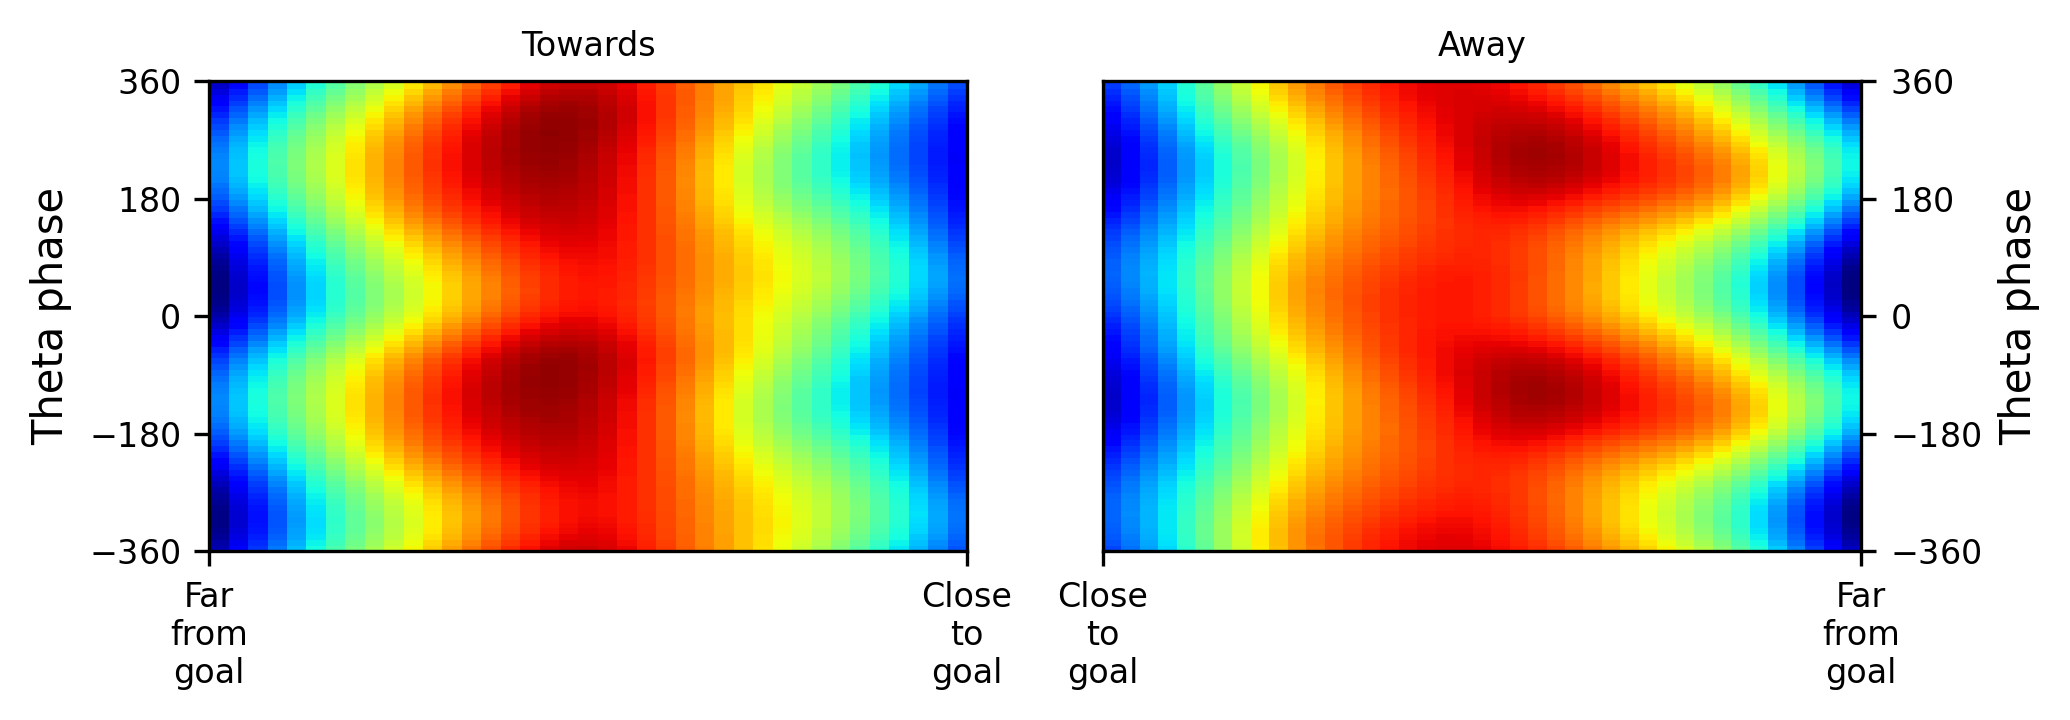

In [75]:
#----------------------- ------------------------------------- --------------------------------- ------------------------------------      
n_bins = 120

SpikePhase_decreasing = np.asarray(SpikePhase_decreasing)
SpikePhase_increasing = np.asarray(SpikePhase_increasing)
Dist2G_decreasing = np.asarray(Dist2G_decreasing)
Dist2G_increasing = np.asarray(Dist2G_increasing)


fig = plt.figure(figsize=(7,2.5), dpi=300)
gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0])

# Wrap phase by duplicating with +2π to handle circularity
SpikePhase_wrapped = np.concatenate([SpikePhase_decreasing, SpikePhase_decreasing + 2 * np.pi, SpikePhase_decreasing + 4*np.pi]) 
Dist2G_wrapped = np.concatenate([Dist2G_decreasing, Dist2G_decreasing, Dist2G_decreasing])
# Compute 2D histogram
heatmap, xedges, yedges = np.histogram2d(Dist2G_wrapped, SpikePhase_wrapped, bins=[n_bins, n_bins])
# Smooth with Gaussian filter
heatmap_smooth = gaussian_filter(heatmap, sigma=4)

sum_heatmap = np.sum(heatmap_smooth, axis=1)
valid_x_indices = sum_heatmap > 0.5 * np.max(sum_heatmap)
# Apply column filter
heatmap_smooth_4_plot = heatmap_smooth[valid_x_indices, :]

# Adjust xedges and X accordingly
xedges_filtered = xedges[:-1][valid_x_indices]  # remove last bin edge, select valid
xedges_filtered = np.append(xedges_filtered, xedges_filtered[-1] + np.diff(xedges).mean())  # match dimension

# Create matching meshgrid
X, Y = np.meshgrid(xedges_filtered, yedges)

# Plot
pcm = ax.pcolormesh(X, Y, heatmap_smooth_4_plot.T, shading='auto', cmap='jet')

#!!!! flip x axis with small values on the right and large values on the left
# Flip the x-axis
ax.invert_xaxis()

width = xedges_filtered.max() - xedges_filtered.min()
xmin = xedges_filtered.min() + 0.0 * width
xmax = xedges_filtered.max() - 0.0 * width
# ax.set_xlim(xmin, xmax)
ax.set_xticks([xmin, xmax])
ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'])

ax.set_ylabel('Theta phase', fontsize=10)
# #activity colorba
ax.set_ylim(np.pi, 5*np.pi) #start from np.pi since we want to make MUA trough as 0 degree, previous is 180 degree
ax.set_yticks([np.pi, 2*np.pi, 3*np.pi, 4*np.pi, 5*np.pi])
ax.set_yticklabels([r'$-360$', r'$-180$', r'$0$', r'$180$', r'$360$'])   
ax.set_title('Towards', fontsize=8)
ax.tick_params(axis='both', which='major', labelsize=8)


#------------------------------- ------------------------------------- --------------------------------- ------------------------------------      

ax = plt.subplot(gs[1])

# Wrap phase by duplicating with +2π to handle circularity
SpikePhase_wrapped = np.concatenate([SpikePhase_increasing, SpikePhase_increasing + 2 * np.pi, SpikePhase_increasing + 4*np.pi]) 
Dist2G_wrapped = np.concatenate([Dist2G_increasing, Dist2G_increasing, Dist2G_increasing])
# Compute 2D histogram
heatmap, xedges, yedges = np.histogram2d(Dist2G_wrapped, SpikePhase_wrapped, bins=[n_bins, n_bins])
# Smooth with Gaussian filter
heatmap_smooth = gaussian_filter(heatmap, sigma=4)
sum_heatmap = np.sum(heatmap_smooth, axis=1)
valid_x_indices = sum_heatmap > 0.5 * np.max(sum_heatmap)
# Apply column filter
heatmap_smooth_4_plot = heatmap_smooth[valid_x_indices, :]

# Adjust xedges and X accordingly
xedges_filtered = xedges[:-1][valid_x_indices]  # remove last bin edge, select valid
xedges_filtered = np.append(xedges_filtered, xedges_filtered[-1] + np.diff(xedges).mean())  # match dimension

# Create matching meshgrid
X, Y = np.meshgrid(xedges_filtered, yedges)

# Plot
pcm = ax.pcolormesh(X, Y, heatmap_smooth_4_plot.T, shading='auto', cmap='jet')

width = xedges_filtered.max() - xedges_filtered.min()
xmin = xedges_filtered.min() + 0.0 * width
xmax = xedges_filtered.max() - 0.0 * width
# ax.set_xlim(xmin, xmax)
ax.set_xticks([xmin, xmax])
ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'])
# ax[0].set_xlabel('Head direction')
# ax.set_xlabel('Dist2Goal', fontsize=10)
#show y axis, ticks labels on the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
    
ax.set_ylabel('Theta phase', fontsize=10)
ax.set_ylim(np.pi, 5*np.pi)  #start from np.pi since we want to make MUA trough as 0 degree, previous is 180 degree
ax.set_yticks([np.pi, 2*np.pi, 3*np.pi, 4*np.pi, 5*np.pi])
ax.set_yticklabels([r'$-360$', r'$-180$', r'$0$', r'$180$', r'$360$'])   
ax.set_title('Away', fontsize=8)
#tickfontsize as 6
ax.tick_params(axis='both', which='major', labelsize=8)

####################################################################################################


plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HoneycombSweeps/figures/PaperFig/phaseprecession2goal.pdf', bbox_inches='tight', dpi=300)


## Section 6: Check anticipatory coding

In [76]:
def get_anticipatory(pc_activity_i, relative_angle, rotation_direction, direction='clockwise', num_bins=36, normalize_rate=False):
    """
    Compute the anticipatory activity of place cells based on relative angles.

    Parameters:
    - pc_activity_i: 1D array of place cell activity.
    - relative_angle: 1D array of relative angles.
    - rotation_direction: 1D array of rotation direction flags (e.g., 1 for CW, -1 for CCW, 0 for stationary).
    - direction: 'clockwise', 'counter_clockwise', or 'nonscanning'
    - num_bins: Number of angular bins.

    Returns:
    - binned_activity: Summed activity per angle bin.
    - dwell_time_per_bin: Number of samples per bin.
    """

    # Filter based on specified rotation direction
    if direction == 'clockwise':
        mask = rotation_direction == 1
    elif direction == 'counter_clockwise':
        mask = rotation_direction == -1
    elif direction == 'nonscanning':
        mask = rotation_direction == 0
    else:
        raise ValueError("Invalid direction. Use 'clockwise', 'counter_clockwise', or 'nonscanning'.")

    activity = pc_activity_i[mask]
    angles = relative_angle[mask]

    # Define bins and digitise
    angle_bins = np.linspace(-np.pi, np.pi, num_bins + 1)
    # bin_indices = np.digitize(angles, angle_bins) - 1
    bin_indices = np.digitize(angles, angle_bins, right=False) - 1
    
    # Clip to valid bin range
    bin_indices = np.clip(bin_indices, 0, num_bins - 1)

    # Initialise outputs
    binned_activity = np.zeros(num_bins)
    dwell_time_per_bin = np.zeros(num_bins)

    # Accumulate values efficiently
    np.add.at(binned_activity, bin_indices, activity)
    np.add.at(dwell_time_per_bin, bin_indices, 1)

    if normalize_rate==True:
        return binned_activity/dwell_time_per_bin
    else:
        return binned_activity
    


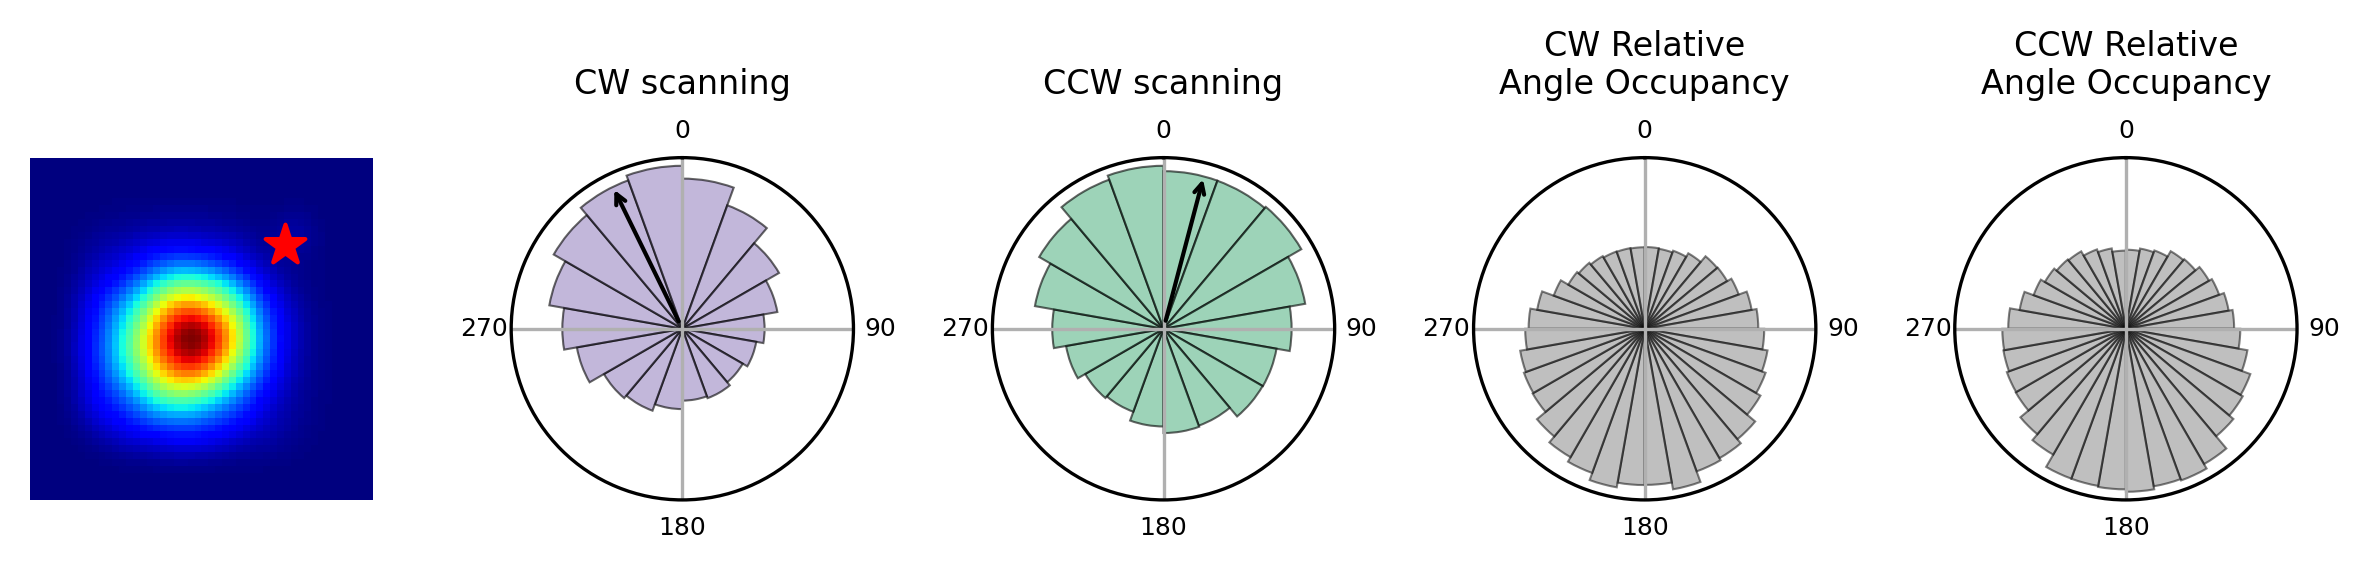

In [81]:
# goal_loc = [0.5*np.pi, 0.5*np.pi]
# goal_loc_in_traj = np.array(goal_loc)/np.pi + 0.5

# rand_loc = [-0.5*np.pi, -0.5*np.pi]

rand_loc = goal_loc

cellindex = [25, 25] #18 #25 #32
#mark the goal location
min_loc = -np.pi
max_loc = np.pi

num = 50
num_bins = 18
normalize_rate = True

pc_activity_i=pc_activity[:, cellindex[0], cellindex[1]]
#cloclwise
relative_angle= get_relativeDir2Goal(Animal_location_all, Head_direction_all, rand_loc)


fig = plt.figure(figsize=(8, 2), dpi=300)

gs = gridspec.GridSpec(1, 5)

ax = fig.add_subplot(gs[0])

# Position_norm = (Animal_location_all - Animal_location_all.min()-1e-5)/(Animal_location_all.max() - Animal_location_all.min())
Position_norm = (Animal_location_all - min_loc-1e-5)/(max_loc - min_loc)
dim = num
tuningMap = get_tuningMap(pc_activity, 
                          Position_norm, 
                          cellindex_x=cellindex[0],
                          cellindex_y=cellindex[1],
                          filter=True,
                          samples_per_sec=1000,
                          dim=dim)

ax.imshow(tuningMap, origin='lower', cmap='jet')

# #mark the goal location
# goal_x = (goal_loc[0]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*(dim-1)
# goal_y = (goal_loc[1]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*(dim-1)


goal_x = (rand_loc[0]- min_loc)/(max_loc - min_loc)*(dim-1)
goal_y = (rand_loc[1]- min_loc)/(max_loc - min_loc)*(dim-1)

ax.scatter(goal_x, goal_y, color='red', marker='*', s=100)

ax.set_aspect('equal')

ax.axis('off')

direction='clockwise'
# direction='counter_clockwise'

# relative_angle= get_relativeDir2Goal(Animal_center_all, Head_direction_all, goal_loc)

# Compute anticipatory activity for clockwise direction
binned_activity = get_anticipatory(pc_activity_i, 
                                   relative_angle, 
                                   Rotation_direction_all, 
                                   direction=direction, 
                                   num_bins=num_bins, 
                                   normalize_rate=normalize_rate)

# Define bins for relative angles from -π to π
angle_bins = np.linspace(-np.pi, np.pi, num_bins + 1)  # 37 edges for 36 bins
bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2  # Compute bin centers

#get the mean angle 
# Weighted circular mean
mean_angle = np.arctan2(
    np.sum(binned_activity * np.sin(bin_centers)),
    np.sum(binned_activity * np.cos(bin_centers))
)
mean_angle_deg = np.rad2deg(mean_angle) % 360

##########################################################################################################################################

ax = fig.add_subplot(gs[1], projection='polar')

if direction=='clockwise':
    color='#9A88C2'
elif direction=='counter_clockwise':
    color='#5CB68A'

bars = ax.bar(
    bin_centers,
    binned_activity,  # exclude the repeated value
    width=2 * np.pi / num_bins,
    bottom=0.0,
    color=color, #'#2167AC', #28A25F
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5
)

if direction == 'clockwise':
    ax.set_title('CW scanning', fontsize=8)
elif direction == 'counter_clockwise':
    ax.set_title('CCW scanning', fontsize=8)
# Set the radial limits

#add mean_angle_deg line as an arrow
mean_angle_rad = np.deg2rad(mean_angle_deg)
r_max = np.max(binned_activity)
ax.annotate('', xy=(mean_angle_rad, r_max), xytext=(0, 0),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=1.0),
            fontsize=6, color='black', label=f'Mean Angle: {mean_angle_deg:.1f}°')


#making 0 degree at the top
ax.set_theta_zero_location('N')
#and 90 degree on the right
ax.set_theta_direction(-1) 
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['0', '90', '180', '270'])
#remove y ticks
ax.set_yticks([])
#xtick fontsize as 6
ax.tick_params(labelsize=6)
ax.xaxis.set_tick_params(pad=-4) 

ax = fig.add_subplot(gs[3], projection='polar')

if direction == 'clockwise':
    mask = Rotation_direction_all == 1  # Only consider rotation phases
elif direction == 'counter_clockwise':
    mask = Rotation_direction_all == -1  # Only consider rotation phases
else:
    mask = Rotation_direction_all == 0
#plot relative angle
ax.hist(relative_angle[mask], bins=36, color='grey', edgecolor='black', linewidth=0.5, alpha=0.5)

ax.set_title('CW Relative\nAngle Occupancy', fontsize=8)
#making 0 degree at the top
ax.set_theta_zero_location('N')
#and 90 degree on the right
ax.set_theta_direction(-1) 
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['0', '90', '180', '270'])
#remove y ticks
ax.set_yticks([])
#xtick fontsize as 6
ax.tick_params(labelsize=6)
ax.xaxis.set_tick_params(pad=-4) 


##########################################################################################################################################

direction='counter_clockwise'

# relative_angle= get_relativeDir2Goal(Animal_center_all, Head_direction_all, goal_loc)

# Compute anticipatory activity for clockwise direction
binned_activity = get_anticipatory(pc_activity_i, 
                                   relative_angle, 
                                   Rotation_direction_all, 
                                   direction=direction, 
                                   num_bins=num_bins, 
                                   normalize_rate=normalize_rate)

# Define bins for relative angles from -π to π
angle_bins = np.linspace(-np.pi, np.pi, num_bins + 1)  # 37 edges for 36 bins
bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2  # Compute bin centers

#get the mean angle 
# Weighted circular mean
mean_angle = np.arctan2(
    np.sum(binned_activity * np.sin(bin_centers)),
    np.sum(binned_activity * np.cos(bin_centers))
)
mean_angle_deg = np.rad2deg(mean_angle) % 360

ax = fig.add_subplot(gs[2], projection='polar')

if direction=='clockwise':
    color='#9A88C2'
elif direction=='counter_clockwise':
    color='#5CB68A'

bars = ax.bar(
    bin_centers,
    binned_activity,  # exclude the repeated value
    width=2 * np.pi / num_bins,
    bottom=0.0,
    color=color, #'#2167AC', #28A25F
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5
)

if direction == 'clockwise':
    ax.set_title('CW scanning', fontsize=8)
elif direction == 'counter_clockwise':
    ax.set_title('CCW scanning', fontsize=8)
# Set the radial limits

#add mean_angle_deg line as an arrow
mean_angle_rad = np.deg2rad(mean_angle_deg)
r_max = np.max(binned_activity)
ax.annotate('', xy=(mean_angle_rad, r_max), xytext=(0, 0),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=1.0),
            fontsize=6, color='black', label=f'Mean Angle: {mean_angle_deg:.1f}°')


#making 0 degree at the top
ax.set_theta_zero_location('N')
#and 90 degree on the right
ax.set_theta_direction(-1) 
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['0', '90', '180', '270'])
#remove y ticks
ax.set_yticks([])
#xtick fontsize as 6
ax.tick_params(labelsize=6)
ax.xaxis.set_tick_params(pad=-4) 

ax = fig.add_subplot(gs[4], projection='polar')

if direction == 'clockwise':
    mask = Rotation_direction_all == 1  # Only consider rotation phases
elif direction == 'counter_clockwise':
    mask = Rotation_direction_all == -1  # Only consider rotation phases
else:
    mask = Rotation_direction_all == 0
#plot relative angle
ax.hist(relative_angle[mask], bins=36, color='grey', edgecolor='black', linewidth=0.5, alpha=0.5)

ax.set_title('CCW Relative\nAngle Occupancy', fontsize=8)
#making 0 degree at the top
ax.set_theta_zero_location('N')
#and 90 degree on the right
ax.set_theta_direction(-1) 
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['0', '90', '180', '270'])
#remove y ticks
ax.set_yticks([])
#xtick fontsize as 6
ax.tick_params(labelsize=6)
ax.xaxis.set_tick_params(pad=-4) 


plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HoneycombSweeps/figures/PaperFig/anticipatory_Acell.pdf', bbox_inches='tight', dpi=300)


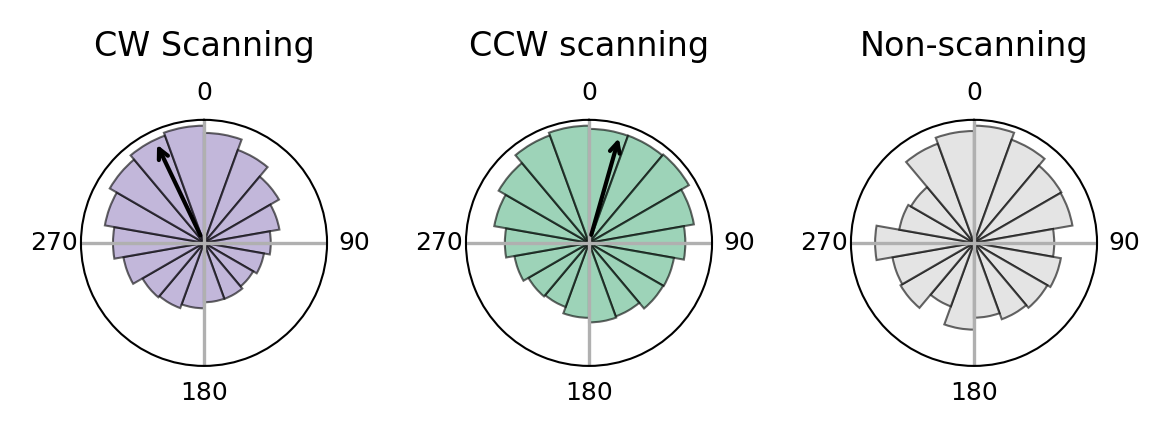

In [80]:
# Define the range of cell indices
start_idx = 20
end_idx = 30  # inclusive

# Define bins for relative angles from -π to π
num_bins = 18
angle_bins = np.linspace(-np.pi, np.pi, num_bins + 1)
bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2

#get relative angles to the goal
relative_angle = get_relativeDir2Goal(Animal_location_all, Head_direction_all, rand_loc)
# relative_angle = get_relativeDir2Goal(Animal_center_all, Head_direction_all, goal_loc)

total_binned_activity_cw = np.zeros(num_bins)  
total_binned_activity_ccw = np.zeros(num_bins)  
total_binned_activity_ns = np.zeros(num_bins) 
 
# Loop through the specified submatrix of cells
for i in range(start_idx, end_idx + 1):
    for j in range(start_idx, end_idx + 1):
        pc_activity_ij = pc_activity[:, i, j]
        
        #cloclwise
        direction = 'clockwise'
        binned_activity = get_anticipatory(pc_activity_ij, relative_angle, Rotation_direction_all, 
                                           direction=direction, num_bins=num_bins, normalize_rate=normalize_rate)
        total_binned_activity_cw += binned_activity  # Accumulate the binned activity across all cells

        #counterclockwise
        direction = 'counter_clockwise'
        binned_activity = get_anticipatory(pc_activity_ij, relative_angle, Rotation_direction_all, 
                                           direction=direction, num_bins=num_bins, normalize_rate=normalize_rate)
        total_binned_activity_ccw += binned_activity  # Accumulate the binned activity across all cells
        
        # nonscanning
        direction = 'nonscanning'
        binned_activity = get_anticipatory(pc_activity_ij, relative_angle, Rotation_direction_all, 
                                           direction=direction, num_bins=num_bins, normalize_rate=normalize_rate)
        total_binned_activity_ns += binned_activity  # Accumulate the binned activity across all cells
        
# Convert bin centers to polar coordinates
theta = np.append(bin_centers, bin_centers[0])

total_binned_activity_cw = np.append(total_binned_activity_cw, total_binned_activity_cw[0])
total_binned_activity_ccw = np.append(total_binned_activity_ccw, total_binned_activity_ccw[0])
total_binned_activity_ns = np.append(total_binned_activity_ns, total_binned_activity_ns[0])

# Bar width based on bin size
bar_width = 2 * np.pi / num_bins

# Create polar plot with bars instead of line
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(4, 2), dpi=300)

ax = axs[0]

bars = ax.bar(
    bin_centers,
    total_binned_activity_cw[:-1],  # exclude the repeated value
    width=bar_width,
    bottom=0.0,
    color='#9A88C2', #'#2167AC', #28A25F
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5
)
#set title
ax.set_title("CW Scanning", fontsize=8)

#get the mean angle
mean_angle_cw = np.arctan2(
    np.sum(total_binned_activity_cw[:-1] * np.sin(bin_centers)),
    np.sum(total_binned_activity_cw[:-1] * np.cos(bin_centers))
)
mean_angle_cw_deg = np.rad2deg(mean_angle_cw) % 360

#add mean_angle_deg line as an arrow
mean_angle_cw_rad = np.deg2rad(mean_angle_cw_deg)

r_max_cw = np.max(total_binned_activity_cw[:-1])


ax.annotate('', xy=(mean_angle_cw_rad, r_max_cw), xytext=(0, 0),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=1.0),
            fontsize=6, color='black', label=f'Mean Angle: {mean_angle_cw_deg:.1f}°')

ax = axs[1]
bars = ax.bar(
    bin_centers,
    total_binned_activity_ccw[:-1],  # exclude the repeated value
    width=bar_width,
    bottom=0.0,
    color='#5CB68A', #orange
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5
)
ax.set_title("CCW scanning", fontsize=8)

#get the mean angle
mean_angle_ccw = np.arctan2(
    np.sum(total_binned_activity_ccw[:-1] * np.sin(bin_centers)),
    np.sum(total_binned_activity_ccw[:-1] * np.cos(bin_centers))
)
mean_angle_ccw_deg = np.rad2deg(mean_angle_ccw) % 360
#add mean_angle_deg line as an arrow
mean_angle_ccw_rad = np.deg2rad(mean_angle_ccw_deg)
r_max_ccw = np.max(total_binned_activity_ccw[:-1])

ax.annotate('', xy=(mean_angle_ccw_rad, r_max_ccw), xytext=(0, 0),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=1.0),
            fontsize=6, color='black', label=f'Mean Angle: {mean_angle_ccw_deg:.1f}°')


ax = axs[2]
bars = ax.bar(
    bin_centers,
    total_binned_activity_ns[:-1],  # exclude the repeated value
    width=bar_width,
    bottom=0.0,
    color='lightgrey',
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5
)
ax.set_title("Non-scanning", fontsize=8)


for ax in axs:
    # Polar aesthetics
    ax.set_theta_zero_location('N')  # 0 at top
    ax.set_theta_direction(-1)       # clockwise
    #only show 0, 90, 180, 270
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
    ax.set_xticklabels(['0', '90', '180', '270'])
    #remove y ticks
    ax.set_yticks([])
    #xtick fontsize as 6
    ax.tick_params(labelsize=6)
    ax.xaxis.set_tick_params(pad=-4) 
    #axis width 0.5
    ax.spines['polar'].set_linewidth(0.5)

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HoneycombSweeps/figures/PaperFig/anticipatory_Allcell.pdf', bbox_inches='tight', dpi=300)

### shuflling 

In [18]:
# ## goal_loc = [0.5*np.pi, 0.5*np.pi]
# # goal_loc_in_traj = np.array(goal_loc)/np.pi + 0.5

# min_loc = -np.pi
# max_loc = np.pi

# direction='clockwise'
# # direction='counter_clockwise'

# num_bins = 18
# normalize_rate = True


# mean_angle_deg_all = []
# #for cell index vary from 20 to 30
# for i in range(13, 31):
#     for j in range(13, 31):

#         cellindex = [i, j]
        
#         print(f'Processing cell index: {cellindex}')

#         pc_activity_i=pc_activity[:, cellindex[0], cellindex[1]]

#         #sampling random_loc from [-0.5*np.pi, 0.5*np.pi]
#         random_loc = np.random.uniform(-0.5*np.pi, 0.5*np.pi, size=(100, 2))

#         for rloc in random_loc:

#             pc_activity_i=pc_activity[:, cellindex[0], cellindex[1]]

#             #cloclwise
#             relative_angle= get_relativeDir2Goal(Animal_location_all, Head_direction_all, rloc)

#             # relative_angle= get_relativeDir2Goal(Animal_center_all, Head_direction_all, goal_loc)

#             # Compute anticipatory activity for clockwise direction
#             binned_activity = get_anticipatory(pc_activity_i, 
#                                             relative_angle, 
#                                             Rotation_direction_all, 
#                                             direction=direction, 
#                                             num_bins=num_bins, 
#                                             normalize_rate=normalize_rate)
            
#             angle_bins = np.linspace(-np.pi, np.pi, num_bins + 1)  # 37 edges for 36 bins
#             bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2  # Compute bin centers
            
#             #get the mean angle 
#             # Weighted circular mean
#             mean_angle = np.arctan2(
#                 np.sum(binned_activity * np.sin(bin_centers)),
#                 np.sum(binned_activity * np.cos(bin_centers))
#             )
#             mean_angle_deg = np.rad2deg(mean_angle) % 360
            
#             mean_angle_deg_all.append(mean_angle_deg)
            
    
# # plot the polor distribution of mean_angle_deg_all



In [19]:

# fig = plt.figure(figsize=(6, 2), dpi=300)

# gs = gridspec.GridSpec(1, 2)

# ax = fig.add_subplot(gs[0], projection='polar')

# if direction=='clockwise':
#     color='#2167AC'
# elif direction=='counter_clockwise':
#     color='#28A25F'
    
# ax.hist(np.deg2rad(mean_angle_deg_all), bins=36, color=color, edgecolor='black', linewidth=0.5, alpha=0.5)
# ax.set_title(direction, fontsize=8)
# #making 0 degree at the top
# ax.set_theta_zero_location('N')
# #and 90 degree on the right
# ax.set_theta_direction(-1)

# # ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
# # ax.set_xticklabels(['0', '90', '180', '270'])

# # #remove y ticks
# # ax.set_yticks([])
# # #xtick fontsize as 6
# # ax.tick_params(labelsize=6)





## Section4: Check consink cell (see Ormond&OKeefe 2022 Nature)

In [20]:
def getSpike_RelativeDirection(consink_loc, Animal_location, Head_direction, spikes):
    """
    Computes the relative direction (in radians) between the head direction and the vector
    pointing from the current position to a candidate sink location, for timepoints where spikes occurred.

    Returns:
        RelativeDirection (ndarray): Vector of relative angles in radians.
        r (float): Mean vector length.
    """
    # Only retain timepoints where spikes occurred
    mask = spikes > 0
    if not np.any(mask):
        return np.array([]), 0.0  # No spikes -> return r=0

    pos = Animal_location[mask]
    hd = Head_direction[mask]

    # Vector from current position to consink
    vec = consink_loc - pos  # shape (N, 2)
    vec_angle = np.arctan2(vec[:, 1], vec[:, 0])  # angle to consink

    # Compute head-relative angle, wrap to [-π, π]
    angle_diff = (vec_angle - hd + np.pi) % (2 * np.pi) - np.pi

    # Mean vector length
    r = cd.resultant_vector_length(angle_diff)

    return angle_diff, r

def get_best_consink_location(consink_x, consink_y, Animal_location_all, Head_direction_all, spikes, top_k=10):
    """
    Perform a grid search over candidate sink locations to find the one that maximises 
    the mean resultant length (MRL), and return the average location of the top K sinks.

    Parameters:
        consink_x (np.ndarray): Candidate sink x-coordinates.
        consink_y (np.ndarray): Candidate sink y-coordinates.
        Animal_location_all (np.ndarray): Animal positions at all timepoints.
        Head_direction_all (np.ndarray): Head directions at all timepoints.
        spikes (np.ndarray): Spike counts at all timepoints.
        top_k (int): Number of top MRLs to average for final sink location.

    Returns:
        mean_sink_loc (np.ndarray): Mean coordinates of top-K sink locations by MRL.
        best_mrl (float): Highest MRL value among all candidates.
        best_RelativeDirection (np.ndarray): Relative direction corresponding to the highest MRL.
        all_mrls (list): All MRL values in grid order.
        all_sinks (list): All sink coordinates in grid order.
    """
    best_mrl = -np.inf
    best_RelativeDirection = None
    all_mrls = []
    all_sinks = []

    for cx in consink_x:
        for cy in consink_y:
            consink_loc = np.array([cx, cy])
            RelativeDirection, mrl_val = getSpike_RelativeDirection(
                consink_loc, Animal_location_all, Head_direction_all, spikes
            )
            all_mrls.append(mrl_val)
            all_sinks.append(consink_loc)

            if mrl_val > best_mrl:
                best_mrl = mrl_val
                best_RelativeDirection = RelativeDirection

    # Convert to arrays for indexing
    all_mrls = np.array(all_mrls)
    all_sinks = np.array(all_sinks)

    # Get indices of top K MRLs
    if len(all_mrls) >= top_k:
        top_indices = np.argsort(all_mrls)[-top_k:]
        mean_sink_loc = np.mean(all_sinks[top_indices], axis=0)
    else:
        mean_sink_loc = np.mean(all_sinks, axis=0)  # fallback if < top_k points

    return mean_sink_loc, best_mrl, best_RelativeDirection


def compute_dwell_normalised_activity(best_RelativeDirection, spikes, num_bins=36):
    
    # Dewell time
    num_bins = 36
    angle_bins = np.linspace(-np.pi, np.pi, num_bins + 1)
    bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2

    bin_indices = np.digitize(best_RelativeDirection, angle_bins) - 1
    # Clip to valid bin range
    bin_indices = np.clip(bin_indices, 0, num_bins - 1)
    dwell_time_per_bin = np.zeros(num_bins)
    spikes_per_bin = np.zeros(num_bins)
    np.add.at(dwell_time_per_bin, bin_indices, 1)
    mask = spikes > 0  # Only consider timepoints with spikes
    np.add.at(spikes_per_bin, bin_indices, spikes[mask])
    activity_per_bin = spikes_per_bin / dwell_time_per_bin
    
    return activity_per_bin, bin_centers



### calculate the best consink location for a cell and compare the relative direction to consink, goal and a random location 

Best consink location: [-0.26455517 -0.95901249]
Max mean vector length (r): 0.304


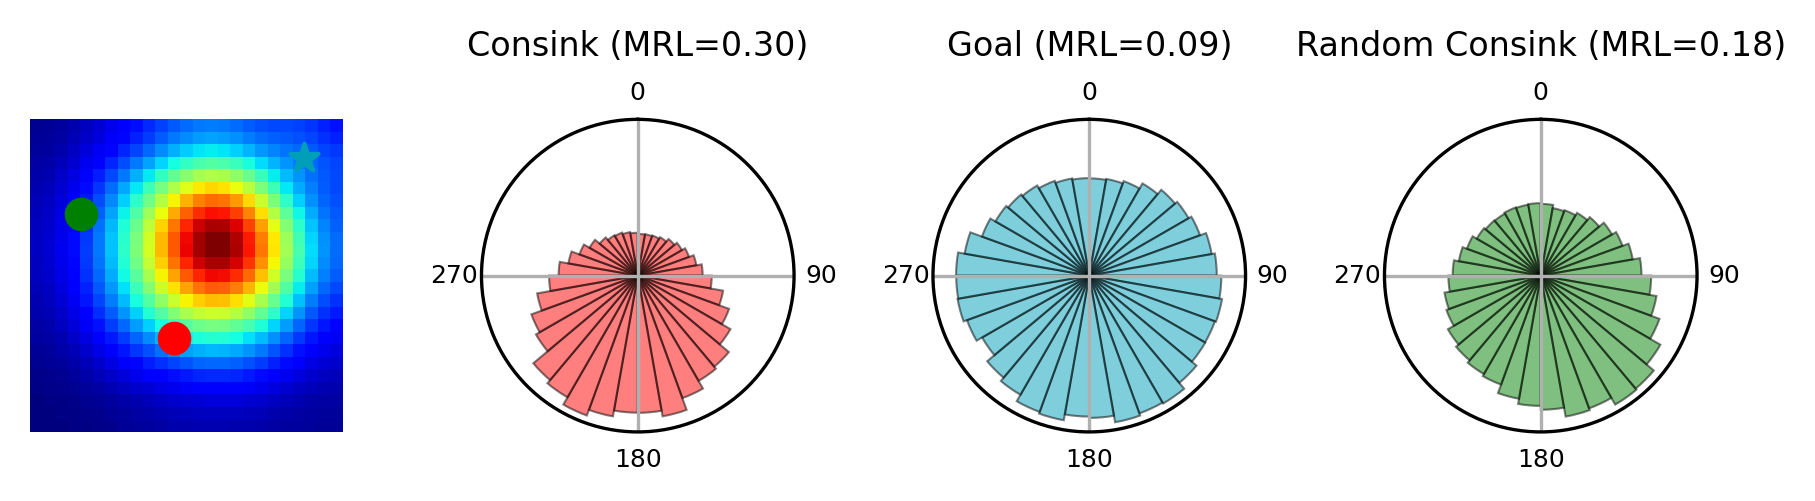

In [21]:
bins = 36
top_k = 1

flag = 0 # 1 for clockwise, -1 for counter-clockwise, 0 for non-scanning

normalize_rate = False

cellindex = [30, 30]  # example cell index

# Sink location grid search parameters
consink_x = np.linspace(-0.5 * np.pi, 0.5 * np.pi, 20)
consink_y = np.linspace(-0.5 * np.pi, 0.5 * np.pi, 20)

r = pc_activity[:, cellindex[0], cellindex[1]]  # firing rate for this cell
# Note the model is a rate-based model so that we need to generate Poisson spike train and 
# for each spike time point, we get the relative direction to the goal
spikes = np.random.poisson(r*10)

#filter
Animal_location_all_filtered = Animal_location_all[Rotation_direction_all!=flag]
Head_direction_all_filtered = Head_direction_all[Rotation_direction_all!=flag]
spikes_filtered = spikes[Rotation_direction_all!=flag]
            
best_sink, best_mrl, best_RelativeDirection = get_best_consink_location(consink_x, consink_y,
                                                                      Animal_location_all_filtered,
                                                                      Head_direction_all_filtered,
                                                                      spikes_filtered,
                                                                      top_k=10)


print(f"Best consink location: {best_sink}")
print(f"Max mean vector length (r): {best_mrl:.3f}")

#ConSink plot
fig = plt.figure(figsize=(6, 2), dpi=300)

gs = gridspec.GridSpec(1, 4)

#-----------------plot place cell firing field and add consink, goal location---------------
ax1 = fig.add_subplot(gs[0])

Position_norm = (Animal_location_all - Animal_location_all.min() - 1e-5)/(Animal_location_all.max() - Animal_location_all.min())
dim = num//2
tuningMap = get_tuningMap(pc_activity, 
                          Position_norm, 
                          cellindex_x=cellindex[0],
                          cellindex_y=cellindex[1],
                          filter=True,
                          samples_per_sec=1000,
                          dim=dim)
ax1.imshow(tuningMap, cmap='jet', origin='lower')

#mark the goal location
goal_x = (goal_loc[0]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*dim
goal_y = (goal_loc[1]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*dim
ax1.scatter(goal_x, goal_y, color='#009FB9', marker='*', s=50, label='Goal')

# mark the best sink location
sink_x = (best_sink[0] - Animal_location_all.min()) / (Animal_location_all.max() - Animal_location_all.min()) * dim
sink_y = (best_sink[1] - Animal_location_all.min()) / (Animal_location_all.max() - Animal_location_all.min()) * dim
ax1.scatter(sink_x, sink_y, color='red', marker='o', s=50, label='Consink')

ax1.axis('off')


#-----------------calculate relative direction to consink------------------
ax = fig.add_subplot(gs[1], projection='polar')


if normalize_rate == False:
    #plot RelativeDirection histogram as a polar plot, with edgecolor as black, facecolor as Non
    ax.hist(best_RelativeDirection, bins=36, color='red', edgecolor='black', linewidth=0.5, alpha=0.5)
else:
    # Compute dwell-normalised activity
    activity_per_bin, bin_centers = compute_dwell_normalised_activity(best_RelativeDirection, spikes_filtered, num_bins=bins)
    bars = ax.bar(
        bin_centers,
        activity_per_bin,  # exclude the repeated value
        width=2 * np.pi / bins,
        bottom=0.0,
        color='red', #'#2167AC', #28A25F
        alpha=0.6,
        edgecolor='black',
        linewidth=0.5
    )

ax.set_title('Consink (MRL=%.2f)' % best_mrl, fontsize=8)

ax.set_theta_zero_location('N')  # 0 at top
ax.set_theta_direction(-1)       # clockwise
#only show 0, 90, 180, 270
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['0', '90', '180', '270'])
#remove y ticks
ax.set_yticks([])
#xtick fontsize as 6
ax.tick_params(labelsize=6)
ax.xaxis.set_tick_params(pad=-4) 
    
#----------------calcluate relative direction to goal------------------

ax = fig.add_subplot(gs[2], projection='polar')

RelativeDirection2Goal, r_val = getSpike_RelativeDirection(
    goal_loc, 
    Animal_location_all_filtered, 
    Head_direction_all_filtered,
    spikes_filtered
)

# RelativeDirection2Goal, r_val = getSpike_RelativeDirection(
#     goal_loc, Animal_center_all, Head_direction_all, spikes
# )

if normalize_rate == False:
    #plot RelativeDirection histogram as a polar plot, with edgecolor as black, facecolor as None
    ax.hist(RelativeDirection2Goal, bins=bins, color='#009FB9', edgecolor='black', linewidth=0.5, alpha=0.5)
else:
    # Compute dwell-normalised activity
    activity_per_bin, bin_centers = compute_dwell_normalised_activity(RelativeDirection2Goal, spikes_filtered, num_bins=bins)
    bars = ax.bar(
        bin_centers,
        activity_per_bin,  # exclude the repeated value
        width=2 * np.pi / bins,
        bottom=0.0,
        color='#009FB9', #'#2167AC', #28A25F
        alpha=0.6,
        edgecolor='black',
        linewidth=0.5
    )

ax.set_title('Goal (MRL=%.2f)' % r_val, fontsize=8)

ax.set_theta_zero_location('N')  # 0 at top
ax.set_theta_direction(-1)       # clockwise
#only show 0, 90, 180, 270
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['0', '90', '180', '270'])
#remove y ticks
ax.set_yticks([])
#xtick fontsize as 6
ax.tick_params(labelsize=6)
ax.xaxis.set_tick_params(pad=-4) 

#----------------calcluate relative direction to a random consink------------------
ax = fig.add_subplot(gs[3], projection='polar')

random_consink_loc = (-0.5 * np.pi, 0.25 * np.pi)

random_consink_loc_x = (random_consink_loc[0]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*dim
random_consink_loc_y = (random_consink_loc[1]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*dim

#add random consink location to the place field plot
ax1.scatter(random_consink_loc_x, random_consink_loc_y, color='green', marker='o', s=50, label='Consink')

RelativeDirection2RS, r_val = getSpike_RelativeDirection(
    random_consink_loc, 
    Animal_location_all_filtered,
    Head_direction_all_filtered,
    spikes_filtered
)

# RelativeDirection2RS, r_val = getSpike_RelativeDirection(
#     random_consink_loc, Animal_center_all, Head_direction_all, spikes
# )


if normalize_rate == False:
    #plot RelativeDirection histogram as a polar plot, with edgecolor as black, facecolor as None
    ax.hist(RelativeDirection2RS, bins=bins, color='green', edgecolor='black', linewidth=0.5, alpha=0.5)
else:
    # Compute dwell-normalised activity
    activity_per_bin, bin_centers = compute_dwell_normalised_activity(RelativeDirection2RS, spikes_filtered, num_bins=bins)
    bars = ax.bar(
        bin_centers,
        activity_per_bin,  # exclude the repeated value
        width=2 * np.pi / bins,
        bottom=0.0,
        color='green', #'#2167AC', #28A25F
        alpha=0.6,
        edgecolor='black',
        linewidth=0.5
    )

ax.set_title('Random Consink (MRL=%.2f)' % r_val, fontsize=8)

ax.set_theta_zero_location('N')  # 0 at top
ax.set_theta_direction(-1)       # clockwise
#only show 0, 90, 180, 270
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['0', '90', '180', '270'])
#remove y ticks
ax.set_yticks([])
#xtick fontsize as 6
ax.tick_params(labelsize=6)
ax.xaxis.set_tick_params(pad=-4) 

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HoneycombSweeps/figures/PaperFig/ConSinkCell.pdf', bbox_inches='tight', dpi=300)


### get the best sink for all cells

In [22]:
consink_x = np.linspace(-0.5 * np.pi, 0.5 * np.pi, 20)
consink_y = np.linspace(-0.5 * np.pi, 0.5 * np.pi, 20)

start_idx = 12
end_idx = 38  # inclusive

Best_MRLs_activeScan = []
Best_Sinks_activeScan  = []

Best_MRLs_inactiveScan = []
Best_Sinks_inactiveScan  = []



for ii in range(start_idx, end_idx + 1, 5):
    for jj in range(start_idx, end_idx + 1, 5):
        
        # print(ii, jj)
        r = pc_activity[:, ii, jj]  # firing rate for this cell
        spikes = np.random.poisson(r*100)
        
        Animal_location_all_filtered = Animal_location_all[Rotation_direction_all!=0]
        Head_direction_all_filtered = Head_direction_all[Rotation_direction_all!=0]
        spikes_filtered = spikes[Rotation_direction_all!=0]

        # Get the best consink location for this cell during activate scanning
        results = get_best_consink_location(consink_x, consink_y,
                                            Animal_location_all_filtered,
                                            Head_direction_all_filtered,
                                            spikes_filtered,
                                            top_k=top_k)
        
        best_sink, best_mrl, best_RelativeDirection = results
        # Store results
        Best_MRLs_activeScan.append(best_mrl)
        Best_Sinks_activeScan.append(best_sink)

        # Get the best consink location for this cell during inactive scanning
        
        Animal_location_all_filtered = Animal_location_all[Rotation_direction_all==0]
        Head_direction_all_filtered = Head_direction_all[Rotation_direction_all==0]
        spikes_filtered = spikes[Rotation_direction_all==0]
        
        results = get_best_consink_location(consink_x, consink_y,
                                            Animal_location_all_filtered,
                                            Head_direction_all_filtered,
                                            spikes_filtered,
                                            top_k=top_k)
        
        best_sink, best_mrl, best_RelativeDirection = results
        # Store results
        Best_MRLs_inactiveScan.append(best_mrl)
        Best_Sinks_inactiveScan.append(best_sink)
        
# for r in AllR:
#     plt.figure()
#     plt.hist(r)

KeyboardInterrupt: 

Max MRL 0.26892898031522183
Max MRL 0.3193186855156653


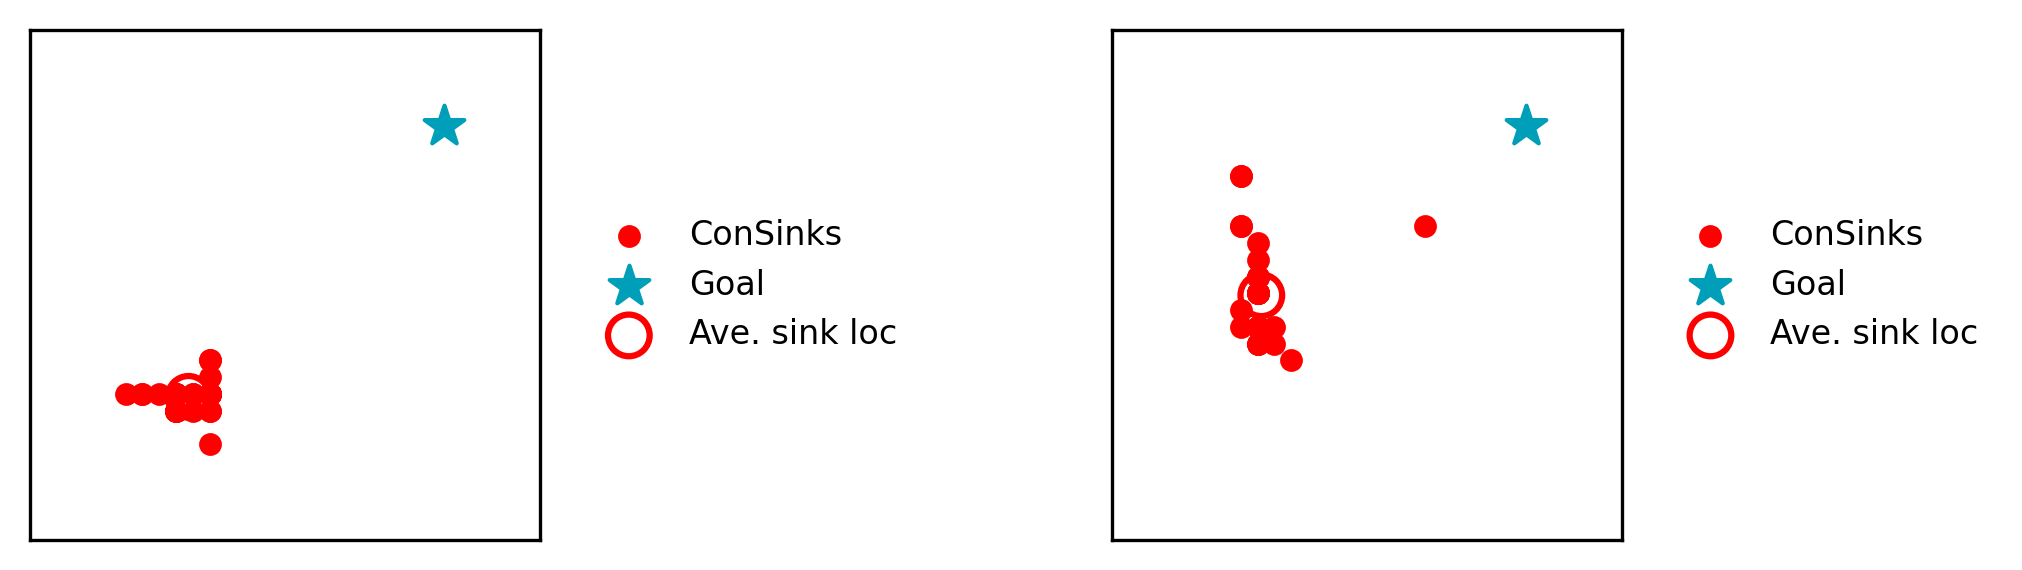

In [ ]:
# Prepare figure
fig = plt.figure(figsize=(8, 2), dpi=300)

gs = gridspec.GridSpec(1, 2)

ax0 = fig.add_subplot(gs[0])

# Convert to arrays
Best_Sinks_activeScan = np.array(Best_Sinks_activeScan)
Best_MRLs_activeScan = np.array(Best_MRLs_activeScan)

print('Max MRL', np.mean(Best_MRLs_activeScan))

for i, sink in enumerate(Best_Sinks_activeScan):
    if i == 0:
        ax0.scatter(sink[0], sink[1], color='red', marker='o', s=20, label='ConSinks')
    else:
        ax0.scatter(sink[0], sink[1], color='red', marker='o', s=20)

ax0.scatter(goal_loc[0], goal_loc[1], color='#009FB9', marker='*', s=100, label='Goal')

# Compute and plot mean best sink (blue star)
mean_sink = np.mean(np.vstack(Best_Sinks_activeScan), axis=0)
ax0.scatter(mean_sink[0], mean_sink[1], facecolors='none', edgecolors='red', marker='o', s=100, linewidth=1.5, label='Ave. sink loc')

#---------------------------------

ax1 = fig.add_subplot(gs[1])

# Convert to arrays
Best_Sinks_inactiveScan = np.array(Best_Sinks_inactiveScan)
Best_MRLs_inactiveScan = np.array(Best_MRLs_inactiveScan)

print('Max MRL', np.mean(Best_MRLs_inactiveScan))

for i, sink in enumerate(Best_Sinks_inactiveScan):
    if i == 0:
        ax1.scatter(sink[0], sink[1], color='red', marker='o', s=20, label='ConSinks')
    else:
        ax1.scatter(sink[0], sink[1], color='red', marker='o', s=20)

ax1.scatter(goal_loc[0], goal_loc[1], color='#009FB9', marker='*', s=100, label='Goal')

# Compute and plot mean best sink (blue star)
mean_sink = np.mean(np.vstack(Best_Sinks_inactiveScan), axis=0)
ax1.scatter(mean_sink[0], mean_sink[1], facecolors='none', edgecolors='red', marker='o', s=100, linewidth=1.5, label='Ave. sink loc')


for ax in [ax0, ax1]:
    ax.legend(fontsize=8, loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)

    ax.set_xlim(-0.8*np.pi, 0.8*np.pi)
    ax.set_ylim(-0.8*np.pi, 0.8*np.pi)
    ax.set_aspect('equal')
    #ticks off
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HoneycombSweeps/figures/ConSinkMap_'+str(goal_loc[0]/np.pi)+'_'+str(goal_loc[1]/np.pi)+'.pdf')